In [1]:
# General
import sys
import os
import os.path as op
import glob
from copy import deepcopy
from time import time
from collections import OrderedDict as od
from importlib import reload
from glob import glob
import itertools
import warnings
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import xarray
import pandas as pd
pd.options.display.max_rows = 200
pd.options.display.max_columns = 999
from scipy import signal
from scipy.io import loadmat
import h5py

# Stats
import scipy.stats as stats
import statsmodels.api as sm
import astropy.stats.circstats as circstats
import pycircstat
import random
from sklearn.decomposition import PCA
import scikits.bootstrap as boot

# Plots
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages

# Neuro
import mne
from fooof import FOOOF, FOOOFGroup
from fooof.objs.utils import combine_fooofs
#import neurodsp

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects')
from formatting import *
from helper_funcs import *
import data_io as dio
import array_operations as aop
from eeg_plotting import plot_trace, plot_trace2
from unit_activity_and_hpc_theta import phase_locking as phlock
from time_cells import spike_sorting, spike_preproc, eeg_preproc, events_preproc, events_proc, spectral_analysis, time_bin_analysis
from phase_locking import eeg_preproc, spectral_analysis, unit_lfp_comparison

# Colors
colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

proj_dir = '/home1/dscho/projects/unit_activity_and_hpc_theta'

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/ptsa/data/TimeSeriesX.py:7: DeprecationWarning: importing from ptsa.data.TimeSeries is deprecated; import from ptsa.data.timeseries instead
  DeprecationWarning)


# Load data

In [4]:
# # Load the older phase-locking dataframe (original manuscript).
# pl_df = phlock.load_pl_df(drop_repeat_connections=False)
# pl_df['subj_sess'] = pl_df['subj_sess'].apply(lambda x: str_replace(x, {'env': 'ses', '1a': '1'}))
# pl_df.insert(pl_df.columns.tolist().index('unit_chan_ind')+1, 'unit_chan', pl_df['unit_chan_ind'] + 1)
# pl_df['subj_sess_unit'] = pl_df.apply(lambda x: '{}-{}-{}'.format(x['subj_sess'], x['unit_chan'], x['unit']), axis=1)
# drop_cols = ['sess', 'subj_unit_chan', 'unit_chan_ind', 'unit_hem',
#              'unit_roi', 'unit_is_hpc', 'lfp_hem', 'lfp_roi', 'lfp_is_hpc',
#              'same_chan', 'same_roi', 'both_hpc', 'unit_hemroi2', 'lfp_hemroi2',
#              'unit_roi2', 'lfp_roi2', 'same_roi2', 'unit_nsamp_spikes', 'spike_inds',
#              'bs_mrls', 'tl_mrls', 'bs_mrls_z', 'tl_mrls_z', 'bs_ind_z', 'tl_locked_freq_z',
#              'tl_locked_time_z', 'tl_locked_mrl_z', 'pref_phase', 'phase_offsets',
#              'pref_phase_tl_locked_time_freq_z', 'phase_offsets_tl_locked_time_freq_z',
#              'unit_roi3', 'roi', 'roi_unit_to_lfp', 'pl_freq', 'pl_strength',
#              'pl_time_shift', 'pl_latency']
# pl_df.drop(columns=[col for col in drop_cols if col in pl_df], inplace=True)
# n_rois = 6
# roi_map = spike_preproc.roi_mapping(n_rois)
# pl_df.insert(pl_df.columns.tolist().index('unit_hemroi')+1, 'unit_roi_gen', pl_df['unit_hemroi'].apply(lambda x: roi_map[x[1:]]))
# pl_df.insert(pl_df.columns.tolist().index('lfp_hemroi')+1, 'lfp_roi_gen', pl_df['lfp_hemroi'].apply(lambda x: roi_map[x[1:]]))
# freqs = np.array([2**((i/2) - 1) for i in range(16)])
# pl_df.insert(pl_df.columns.tolist().index('locked_freq_ind_z')+1, 'locked_freq_z',
#              pl_df['locked_freq_ind_z'].apply(lambda x: np.round(freqs[x], 1)))
# pl_df = (pl_df.query("(edge==['ctx-local', 'hpc-local', 'ctx-hpc', 'hpc-hpc'])")
#               .sort_values(['subj_sess_unit', 'edge'])
#               .reset_index(drop=True))
# print('pl_df: {}'.format(pl_df.shape))

pl_df: (4672, 22)


In [25]:
# Load spikes.
fr_thresh = 0.2
nspike_thresh = 0
n_rois = 6
expmts = ['ycab', 'goldmine']

# ----------------------
spikes = []
for expmt in expmts:
    print(expmt)
    spikes.append(unit_lfp_comparison.load_all_unit_spikes(fr_thresh=fr_thresh,
                                                           nspike_thresh=nspike_thresh,
                                                           n_rois=n_rois,
                                                           expmt=expmt))
    spikes[-1].insert(0, 'expmt', expmt)
spikes = pd.concat(spikes, axis=0).reset_index(drop=True)

if 'subj_sess_unit' not in spikes:
    spikes.insert(1, 'subj_sess_unit', spikes.apply(lambda x: '{}-{}-{}'.format(x['subj_sess'], x['chan'], x['unit']), axis=1))
    
n_rois = 8
roi_map = spike_preproc.roi_mapping(n_rois)
spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])

print('spikes:', spikes.shape)

ycab
spikes: (1633, 10)
Ran in 14.6s
goldmine
10 subjects, 12 sessions
spikes: (448, 10)
Ran in 34.9s
spikes: (2081, 12)


In [45]:
expmts = ['ycab', 'goldmine_nav']
data_dir = {'ycab': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/ycab',
            'goldmine_nav': '/home1/dscho/projects/unit_activity_and_hpc_theta/data2/goldmine/nav'}
freqs = np.arange(1, 31)
n_rois = 8
min_spikes = 50
alpha = 0.05

# -----------------------
timer = Timer()

pl_files = []
pl_mrls = []
for expmt in expmts:
    pl_files.append(glob(op.join(data_dir[expmt], 'phase_locking', 'osc2mask', '*.pkl')))
    pl_mrls.append(pd.concat([dio.open_pickle(f) for f in pl_files[-1]])
                     .sort_values(['subj_sess', 'unit', 'lfp_roi_gen'])
                     .reset_index(drop=True))
    pl_mrls[-1].insert(0, 'expmt', expmt)
pl_mrls = pd.concat(pl_mrls).reset_index(drop=True)
pl_mrls.insert(1,
               'subj_sess_unit',
               pl_mrls.apply(lambda x: '{}-{}'.format(x['subj_sess'], x['unit']), axis=1))
pl_mrls.insert(pl_mrls.columns.tolist().index('edge')+1,
               'is_local',
               pl_mrls['unit_hemroi'] == pl_mrls['lfp_hemroi'])
pl_mrls.insert(pl_mrls.columns.tolist().index('n_spikes_mask')+1,
               'max_n_spikes_mask',
               pl_mrls['n_spikes_mask'].apply(lambda x: np.nanmax(x)))
pl_mrls.insert(pl_mrls.columns.tolist().index('n_spikes_mask_null')+1,
               'max_n_spikes_mask_null',
               pl_mrls['n_spikes_mask_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls')+1,
               'max_mrl',
               pl_mrls['mrls'].apply(lambda x: np.nanmax(x)))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls')+2,
               'max_mrl_freq',
               pl_mrls['mrls'].apply(lambda x: freqs[np.nanargmax(x)]))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls_null')+1,
               'max_mrl_null',
               pl_mrls['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(x, axis=1))))
pl_mrls.insert(pl_mrls.columns.tolist().index('mrls_null')+2,
               'max_mrl_freq_null',
               pl_mrls['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(x, axis=1), nan_policy='omit').mode[0]]))
pl_mrls.insert(pl_mrls.columns.tolist().index('pref_phases')+1,
               'max_pref_phase',
               pl_mrls.apply(lambda x: x['pref_phases'][np.nanargmax(x['mrls'])], axis=1))
pl_mrls.insert(pl_mrls.columns.tolist().index('pref_phases')+2,
               'max_z_pref_phase',
               pl_mrls.apply(lambda x: x['pref_phases'][np.nanargmax(x['z_mrls'])], axis=1))
pl_mrls.insert(pl_mrls.columns.tolist().index('max_z_mrl_freq')+1,
               'max_z_mrl_null',
               pl_mrls['mrls_null'].apply(lambda x: np.nanmean(np.nanmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1))))
pl_mrls.insert(pl_mrls.columns.tolist().index('max_z_mrl_freq')+2,
               'max_z_mrl_freq_null',
               pl_mrls['mrls_null'].apply(lambda x: freqs[stats.mode(np.nanargmax(stats.zscore(x, axis=0, nan_policy='omit'), axis=1), nan_policy='omit').mode[0]]))
pl_mrls.drop(columns=['mrls_null'], inplace=True)

# Reformat regions.
roi_map = spike_preproc.roi_mapping(n_rois)
spikes['roi_gen'] = spikes['hemroi'].apply(lambda x: roi_map[x[1:]])
for cxn in ['unit', 'lfp']:
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: roi_map[x[1:]])
drop_idx = pl_mrls.loc[np.isin(pl_mrls['unit_roi_gen'], 'Other') | np.isin(pl_mrls['lfp_roi_gen'], 'Other')].index
pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

drop_rois = ['MC', 'PC', 'TP']
hpc_rois = ['AH', 'MH', 'PH']
mtl_rois = ['A', 'EC', 'PHG', 'FSG', 'PHG-FSG', 'PG']
gen_rois = ['HPC', 'EC', 'AMY', 'OFC', 'PHG', 'ACC', 'STG']
gen_rois2 = ['HPC', 'MTL', 'CTX']
for cxn in ['unit', 'lfp']:
    pl_mrls.insert(pl_mrls.columns.tolist().index('{}_hemroi'.format(cxn))+1,
                   '{}_roi'.format(cxn),
                   pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]))
    pl_mrls = pl_mrls.query("({}_roi!={})".format(cxn, drop_rois)).reset_index(drop=True)
    
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(str)
    pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='CC', '{}_roi_gen'.format(cxn)] = 'ACC'
    pl_mrls.loc[pl_mrls['{}_roi_gen'.format(cxn)]=='LTC', '{}_roi_gen'.format(cxn)] = 'STG'
    pl_mrls['{}_roi_gen'.format(cxn)] = pl_mrls['{}_roi_gen'.format(cxn)].astype(pd.CategoricalDtype(gen_rois, ordered=True))
    
    pl_mrls.insert(pl_mrls.columns.tolist().index('{}_roi_gen'.format(cxn))+1, '{}_roi_gen2'.format(cxn), '')
    pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois), '{}_roi_gen2'.format(cxn)] = 'HPC'
    pl_mrls.loc[np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), mtl_rois), '{}_roi_gen2'.format(cxn)] = 'MTL'
    pl_mrls.loc[~np.isin(pl_mrls['{}_hemroi'.format(cxn)].apply(lambda x: x[1:]), hpc_rois + mtl_rois), '{}_roi_gen2'.format(cxn)] = 'CTX'
    pl_mrls['{}_roi_gen2'.format(cxn)] = pl_mrls['{}_roi_gen2'.format(cxn)].astype(pd.CategoricalDtype(gen_rois2, ordered=True))

pl_mrls.insert(pl_mrls.columns.tolist().index('lfp_hemroi')+1, 'lfp_hpc_div', '')
pl_mrls.loc[np.isin(pl_mrls['lfp_hemroi'], ['LAH', 'RAH']), 'lfp_hpc_div'] = 'ant'
pl_mrls.loc[np.isin(pl_mrls['lfp_hemroi'], ['LMH', 'LPH', 'RMH', 'RPH']), 'lfp_hpc_div'] = 'post'

# Drop repeat connections.
mult_edge_neurons = (pl_mrls
                     .query("(edge==['ctx-hpc', 'hpc-hpc'])")
                     .groupby(['mask', 'same_hem', 'subj_sess_unit'])
                     .size()
                     .reset_index()
                     .rename(columns={0: 'n_edges'})
                     .query("(n_edges>1)")['subj_sess_unit']
                     .unique()
                     .tolist())
qry = "(edge==['ctx-hpc', 'hpc-hpc']) & (subj_sess_unit=={})".format(mult_edge_neurons)
drop_idx = np.concatenate([unit_lfp_comparison.axe_connections(df)
                           for (idx, df) in pl_mrls.query(qry).groupby('subj_sess_unit')])
pl_mrls = pl_mrls.drop(index=drop_idx).reset_index(drop=True)

# Drop contralateral connections.
pl_mrls = pl_mrls.query("(same_hem==True)").reset_index(drop=True)

# Drop neurons with too few spikes.
pl_mrls = pl_mrls.query("(max_n_spikes_mask>={})".format(min_spikes)).reset_index(drop=True)

# Drop nonlocal connections within the same general region.
drop_idx = pl_mrls.query("(same_roi_gen==True) & (is_local==False)").index.tolist()
pl_mrls.drop(index=drop_idx, inplace=True)

# # Keep only local connections and connections to hippocampal LFPs.
# pl_mrls = pl_mrls.query("(is_local==True) | (lfp_roi_gen=='HPC')").reset_index(drop=True)

# FDR correct p-values, separately within each unit-to-LFP region pair.
pl_mrls.drop(columns=[col for col in list(set(['pval_fdr', 'sig_fdr']) & set(pl_mrls.columns))], inplace=True)
pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+1, 'pval_fdr', np.nan)
pl_mrls.insert(pl_mrls.columns.tolist().index('sig')+2, 'sig_fdr', np.nan)

for (mask, unit_roi_gen, lfp_roi_gen), df in pl_mrls.groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'], observed=True):
    sig_fdr, pval_fdr, *_ = sm.stats.multipletests(df['pval'], alpha=alpha, method='fdr_tsbky')
    pl_mrls.loc[df.index, 'pval_fdr'] = pval_fdr
    pl_mrls.loc[df.index, 'sig_fdr'] = sig_fdr
    
print('{} saved files'.format(np.sum([len(x) for x in pl_files])))
print('pl_mrls: {}'.format(pl_mrls.shape))
print('{} subjects, {} sessions, {} neurons'
      .format(pl_mrls['subj'].unique().size,
              pl_mrls['subj_sess'].unique().size,
              pl_mrls['subj_sess_unit'].unique().size))
print(timer)

1903 saved files
pl_mrls: (7506, 50)
28 subjects, 55 sessions, 1580 neurons
Ran in 87.6s


# How many neurons?

In [34]:
print('{} subjects, {} sessions, {} neurons'
      .format(pl_mrls['subj'].unique().size,
              pl_mrls['subj_sess'].unique().size,
              pl_mrls['subj_sess_unit'].unique().size))

28 subjects, 55 sessions, 1115 neurons


In [38]:
# How many neuron-LFP connections do we have between each pair of regions?
(pl_mrls
 .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'])
 .size()
 .unstack('lfp_roi_gen'))

lfp_roi_gen                HPC  AMY  EC  PHG  OFC  CC  LTC
mask         unit_roi_gen                                 
lfp_and_unit HPC             0    0   0    0    0   0    0
             AMY           259    0   0    0    0   0    0
             EC            210    0   0    0    0   0    0
             PHG           101    0   0    0    0   0    0
             OFC           122    0   0    0    0   0    0
             CC            127    0   0    0    0   0    0
             LTC            98    0   0    0    0   0    0
lfp_not_unit HPC             0    0   0    0    0   0    0
             AMY           260    0   0    0    0   0    0
             EC            235    0   0    0    0   0    0
             PHG           145    0   0    0    0   0    0
             OFC           145    0   0    0    0   0    0
             CC            160    0   0    0    0   0    0
             LTC           123    0   0    0    0   0    0

In [37]:
# How many subjects have neuron-LFP connections between each pair of regions?
(pl_mrls
 .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'])
 ['subj'].apply(lambda x: len(np.unique(x)))
 .unstack('lfp_roi_gen')
 .fillna(0))

lfp_roi_gen                 HPC  AMY   EC  PHG  OFC   CC  LTC
mask         unit_roi_gen                                    
lfp_and_unit HPC            0.0  0.0  0.0  0.0  0.0  0.0  0.0
             AMY           21.0  0.0  0.0  0.0  0.0  0.0  0.0
             EC            17.0  0.0  0.0  0.0  0.0  0.0  0.0
             PHG           14.0  0.0  0.0  0.0  0.0  0.0  0.0
             OFC           13.0  0.0  0.0  0.0  0.0  0.0  0.0
             CC             9.0  0.0  0.0  0.0  0.0  0.0  0.0
             LTC            6.0  0.0  0.0  0.0  0.0  0.0  0.0
lfp_not_unit HPC            0.0  0.0  0.0  0.0  0.0  0.0  0.0
             AMY           22.0  0.0  0.0  0.0  0.0  0.0  0.0
             EC            17.0  0.0  0.0  0.0  0.0  0.0  0.0
             PHG           15.0  0.0  0.0  0.0  0.0  0.0  0.0
             OFC           14.0  0.0  0.0  0.0  0.0  0.0  0.0
             CC            10.0  0.0  0.0  0.0  0.0  0.0  0.0
             LTC            6.0  0.0  0.0  0.0  0.0  0.0  0.0

# Phase-locking significance

In [61]:
(pl_mrls
 .groupby(['mask', 'unit_roi_gen', 'lfp_roi_gen'], observed=True)
 .agg({'sig': count_pct,
       'sig_fdr': count_pct})
 .unstack(['unit_roi_gen']))

sig                                  \
unit_roi_gen                         HPC              EC             AMY   
mask         lfp_roi_gen                                                   
lfp_and_unit HPC                     NaN  89/210 (42.4%)  74/259 (28.6%)   
             EC           47/147 (32.0%)             NaN  49/188 (26.1%)   
             AMY          51/154 (33.1%)  40/138 (29.0%)             NaN   
             OFC           10/95 (10.5%)    8/121 (6.6%)  29/127 (22.8%)   
             PHG          36/107 (33.6%)   13/89 (14.6%)  25/102 (24.5%)   
             ACC             3/62 (4.8%)   13/91 (14.3%)    6/106 (5.7%)   
             STG            6/43 (14.0%)   11/75 (14.7%)   12/42 (28.6%)   
lfp_not_unit HPC                     NaN  58/235 (24.7%)  66/260 (25.4%)   
             EC           21/157 (13.4%)             NaN  46/208 (22.1%)   
             AMY          38/170 (22.4%)  29/179 (16.2%)             NaN   
             OFC           13/136 (9.6%)   13/133 (9.8%)  19/155 (12.3%)   
             PHG          15/126 (11.9%)   11/118 (9.3%)  26/121 (21.5%)   
             ACC             3/81 (3.7%)  13/106 (12.3%)    6/120 (5.0%)   
             STG             5/55 (9.1%)    7/106 (6.6%)   11/60 (18.3%)   

                                                                        \
unit_roi_gen                        OFC             PHG            ACC   
mask         lfp_roi_gen                                                 
lfp_and_unit HPC          10/122 (8.2%)    8/101 (7.9%)  12/77 (15.6%)   
             EC           11/77 (14.3%)     4/71 (5.6%)    6/70 (8.6%)   
             AMY           9/104 (8.7%)     7/97 (7.2%)   8/51 (15.7%)   
             OFC                    NaN    6/31 (19.4%)   6/60 (10.0%)   
             PHG           9/33 (27.3%)             NaN     0/9 (0.0%)   
             ACC            3/35 (8.6%)      0/7 (0.0%)            NaN   
             STG            1/15 (6.7%)    2/15 (13.3%)     0/2 (0.0%)   
lfp_not_unit HPC          10/145 (6.9%)  20/145 (13.8%)    9/96 (9.4%)   
             EC             9/97 (9.3%)    2/103 (1.9%)    5/84 (6.0%)   
             AMY           3/125 (2.4%)    8/142 (5.6%)    3/57 (5.3%)   
             OFC                    NaN     3/41 (7.3%)    5/71 (7.0%)   
             PHG           6/40 (15.0%)             NaN     0/8 (0.0%)   
             ACC            2/52 (3.8%)     1/9 (11.1%)            NaN   
             STG            2/22 (9.1%)    4/18 (22.2%)     0/3 (0.0%)   

                                                sig_fdr                  \
unit_roi_gen                        STG             HPC              EC   
mask         lfp_roi_gen                                                  
lfp_and_unit HPC          18/97 (18.6%)             NaN  77/210 (36.7%)   
             EC            5/34 (14.7%)  33/147 (22.4%)             NaN   
             AMY          10/53 (18.9%)  39/154 (25.3%)  34/138 (24.6%)   
             OFC           3/26 (11.5%)     3/95 (3.2%)    0/121 (0.0%)   
             PHG            2/33 (6.1%)  30/107 (28.0%)     7/89 (7.9%)   
             ACC           2/19 (10.5%)     0/62 (0.0%)     3/91 (3.3%)   
             STG                    NaN     3/43 (7.0%)     0/75 (0.0%)   
lfp_not_unit HPC           6/114 (5.3%)             NaN  33/235 (14.0%)   
             EC             5/51 (9.8%)   11/157 (7.0%)             NaN   
             AMY            6/73 (8.2%)  18/170 (10.6%)    4/179 (2.2%)   
             OFC            2/30 (6.7%)    0/136 (0.0%)    3/133 (2.3%)   
             PHG            2/38 (5.3%)    5/126 (4.0%)    0/118 (0.0%)   
             ACC            2/21 (9.5%)     0/81 (0.0%)    3/106 (2.8%)   
             STG                    NaN     0/55 (0.0%)    0/106 (0.0%)   

                                                                      \
unit_roi_gen                         AMY           OFC           PHG   
mask         lfp_roi_gen                                         

In [6]:
(pl_mrls
 .query("(same_hem==True) & (max_n_spikes_mask>={})".format(min_spikes))
 .groupby(['mask', 'edge', 'unit_roi_gen'], observed=True)
 .agg({'sig': count_pct})
 .unstack(['mask']))

sig                
mask                    lfp_and_unit    lfp_not_unit
edge    unit_roi_gen                                
ctx-hpc EC            99/241 (41.1%)  56/255 (22.0%)
        A             80/301 (26.6%)  78/313 (24.9%)
        PHG-FSG         9/140 (6.4%)  20/168 (11.9%)
        mPFC           25/256 (9.8%)   16/291 (5.5%)
        O             38/244 (15.6%)  34/286 (11.9%)

In [8]:
(pl_mrls
 .query("(sig==True) & (same_hem==True) & (max_n_spikes_mask>={})".format(min_spikes))
 .groupby(['mask', 'edge', 'unit_roi_gen'], observed=True)
 .agg({'unit': len,
       'max_n_spikes_mask': mean_sem,
       'max_z_mrl': mean_sem,
       'max_z_mrl_freq': gmean_sem})
 .unstack(['mask']))

unit              max_n_spikes_mask  \
mask                 lfp_and_unit lfp_not_unit      lfp_and_unit   
edge    unit_roi_gen                                               
ctx-hpc EC                     99           56   805.56 ± 167.06   
        A                      80           78    462.86 ± 59.59   
        PHG-FSG                 9           20    231.66 ± 54.12   
        mPFC                   25           16    259.01 ± 38.21   
        O                      38           34   625.64 ± 203.20   

                                         max_z_mrl               \
mask                     lfp_not_unit lfp_and_unit lfp_not_unit   
edge    unit_roi_gen                                              
ctx-hpc EC            831.56 ± 219.52  7.46 ± 0.50  6.54 ± 0.63   
        A              487.44 ± 66.74  7.10 ± 0.47  6.57 ± 0.49   
        PHG-FSG        347.16 ± 49.45  4.17 ± 0.12  4.25 ± 0.24   
        mPFC           277.24 ± 94.24  5.41 ± 0.52  4.31 ± 0.24   
        O             834.86 ± 288.47  4.64 ± 0.23  4.27 ± 0.15   

                     max_z_mrl_freq                
mask                   lfp_and_unit  lfp_not_unit  
edge    unit_roi_gen                               
ctx-hpc EC              5.59 ± 1.07   6.91 ± 1.08  
        A               3.83 ± 1.07   4.54 ± 1.09  
        PHG-FSG         6.15 ± 1.33  10.38 ± 1.18  
        mPFC            5.10 ± 1.16  11.80 ± 1.22  
        O               8.04 ± 1.12   6.84 ± 1.15

In [152]:
def _bootstrap(data,
               statistic=np.mean,
               n_resamples=10000,
               confidence_level=0.95,
               thresh=None):
    """Compute a two-sided bootstrap confidence interval of a statistic."""
    n_obs = len(data)
    sample_stats = np.array([statistic(np.random.choice(data, n_obs, replace=True))
                             for _ in range(n_resamples)])
    q = (0.5 - (confidence_level/2), 0.5 + (confidence_level/2))
    conf_int = np.quantile(sample_stats, q)
    
    if thresh is not None:
        pval = (1 + np.count_nonzero(~(sample_stats > thresh))) / (1 + n_resamples)
        return conf_int, pval
    
    return (conf_int,)

In [41]:
dat.groupby(['band', 'unit_roi_gen']).agg({'sig': lambda x: stats.ttest_1samp(x, popmean=5)[1] * 0.5})  # make it a one-sided test

sig
band       unit_roi_gen          
slow_theta EC            0.034449
           A             0.022039
           PHG-FSG       0.263594
           mPFC          0.045954
           O             0.144412
fast_theta EC            0.008346
           A             0.005468
           PHG-FSG       0.406810
           mPFC          0.174794
           O             0.475391
beta       EC            0.075426
           A             0.306597
           PHG-FSG       0.004594
           mPFC          0.490464
           O             0.102420

In [33]:
mean_dat[('sig', 'ci95')] = mean_dat.apply(lambda x: (x[('sig', 'mean')] - (1.96 * x[('sig', 'sem')]),
                                                      x[('sig', 'mean')] + (1.96 * x[('sig', 'sem')])),
                                          axis=1)

In [34]:
mean_dat

sig             \
                              mean        sem   
band       unit_roi_gen                         
slow_theta EC            19.728618   6.656759   
           A             25.451817   8.346145   
           PHG-FSG        6.326324   1.917530   
           mPFC           8.262468   1.671415   
           O             18.595798  11.846798   
fast_theta EC            27.329751   6.794907   
           A             20.518807   4.272486   
           PHG-FSG        5.605128   2.403422   
           mPFC           7.129142   2.099156   
           O              5.140408   2.181974   
beta       EC            15.043156   6.101329   
           A              6.203941   2.234841   
           PHG-FSG        8.119658   0.757508   
           mPFC           5.049139   1.983749   
           O              2.912484   1.467926   

                                                                    
                                                              ci95  
band       unit_roi_gen                                             
slow_theta EC               (6.681370503640869, 32.77586538216645)  
           A               (9.093372648373574, 41.810260755259826)  
           PHG-FSG        (2.5679657208771878, 10.084683057932581)  
           mPFC              (4.986495050237039, 11.5384403065456)  
           O               (-4.623925366185805, 41.81552218544219)  
fast_theta EC               (14.011733744026536, 40.6477675496211)  
           A               (12.14473500613816, 28.892879303590096)  
           PHG-FSG         (0.8944213930567395, 10.31583501719967)  
           mPFC             (3.014795944344539, 11.24348801440025)  
           O               (0.8637399371927801, 9.417076554803838)  
beta       EC             (3.0845516436168605, 27.001759560706766)  
           A               (1.8236522983656682, 10.58422872844119)  
           PHG-FSG          (6.634942408263242, 9.604373831052996)  
           mPFC            (1.1609908571585805, 8.937288111110492)  
           O             (0.035349305485131044, 5.789618519482692)

In [46]:
dat.groupby(['band', 'unit_roi_gen']).agg({'sig': lambda x: _bootstrap(x, np.mean)})

sig
band       unit_roi_gen                                             
slow_theta EC             ([9.878269878269878, 27.720069282569277],)
           A             ([21.035998209609325, 46.072995163272935],)
           PHG-FSG        ([4.749192562015059, 14.278555781474381],)
           mPFC           ([4.286401061895169, 11.008865040804315],)
           O              ([4.073984526112186, 36.321480765097775],)
fast_theta EC             ([16.829855289746884, 44.47199418066627],)
           A              ([11.52935769877299, 28.488666505907887],)
           PHG-FSG                  ([3.0448717948717947, 19.6875],)
           mPFC           ([2.2657450076804913, 9.168586789554531],)
           O             ([1.6483516483516485, 10.748140748140749],)
beta       EC             ([5.844155844155844, 22.862156289033738],)
           A              ([4.758590727260806, 21.042456726280253],)
           PHG-FSG          ([3.307692307692308, 8.76923076923077],)
           mPFC            ([1.034816247582205, 6.821582446087639],)
           O               ([0.900900900900901, 7.857857857857856],)

In [45]:
dat.groupby(['band', 'unit_roi_gen']).agg({'sig': lambda x: _bootstrap(x, np.mean, thresh=5)[1]})

sig
band       unit_roi_gen          
slow_theta EC            0.000500
           A             0.000100
           PHG-FSG       0.028597
           mPFC          0.065093
           O             0.061494
fast_theta EC            0.000100
           A             0.000200
           PHG-FSG       0.113389
           mPFC          0.377762
           O             0.384562
beta       EC            0.016298
           A             0.030697
           PHG-FSG       0.213779
           mPFC          0.808719
           O             0.677032

min = 0.0, max = 100.0


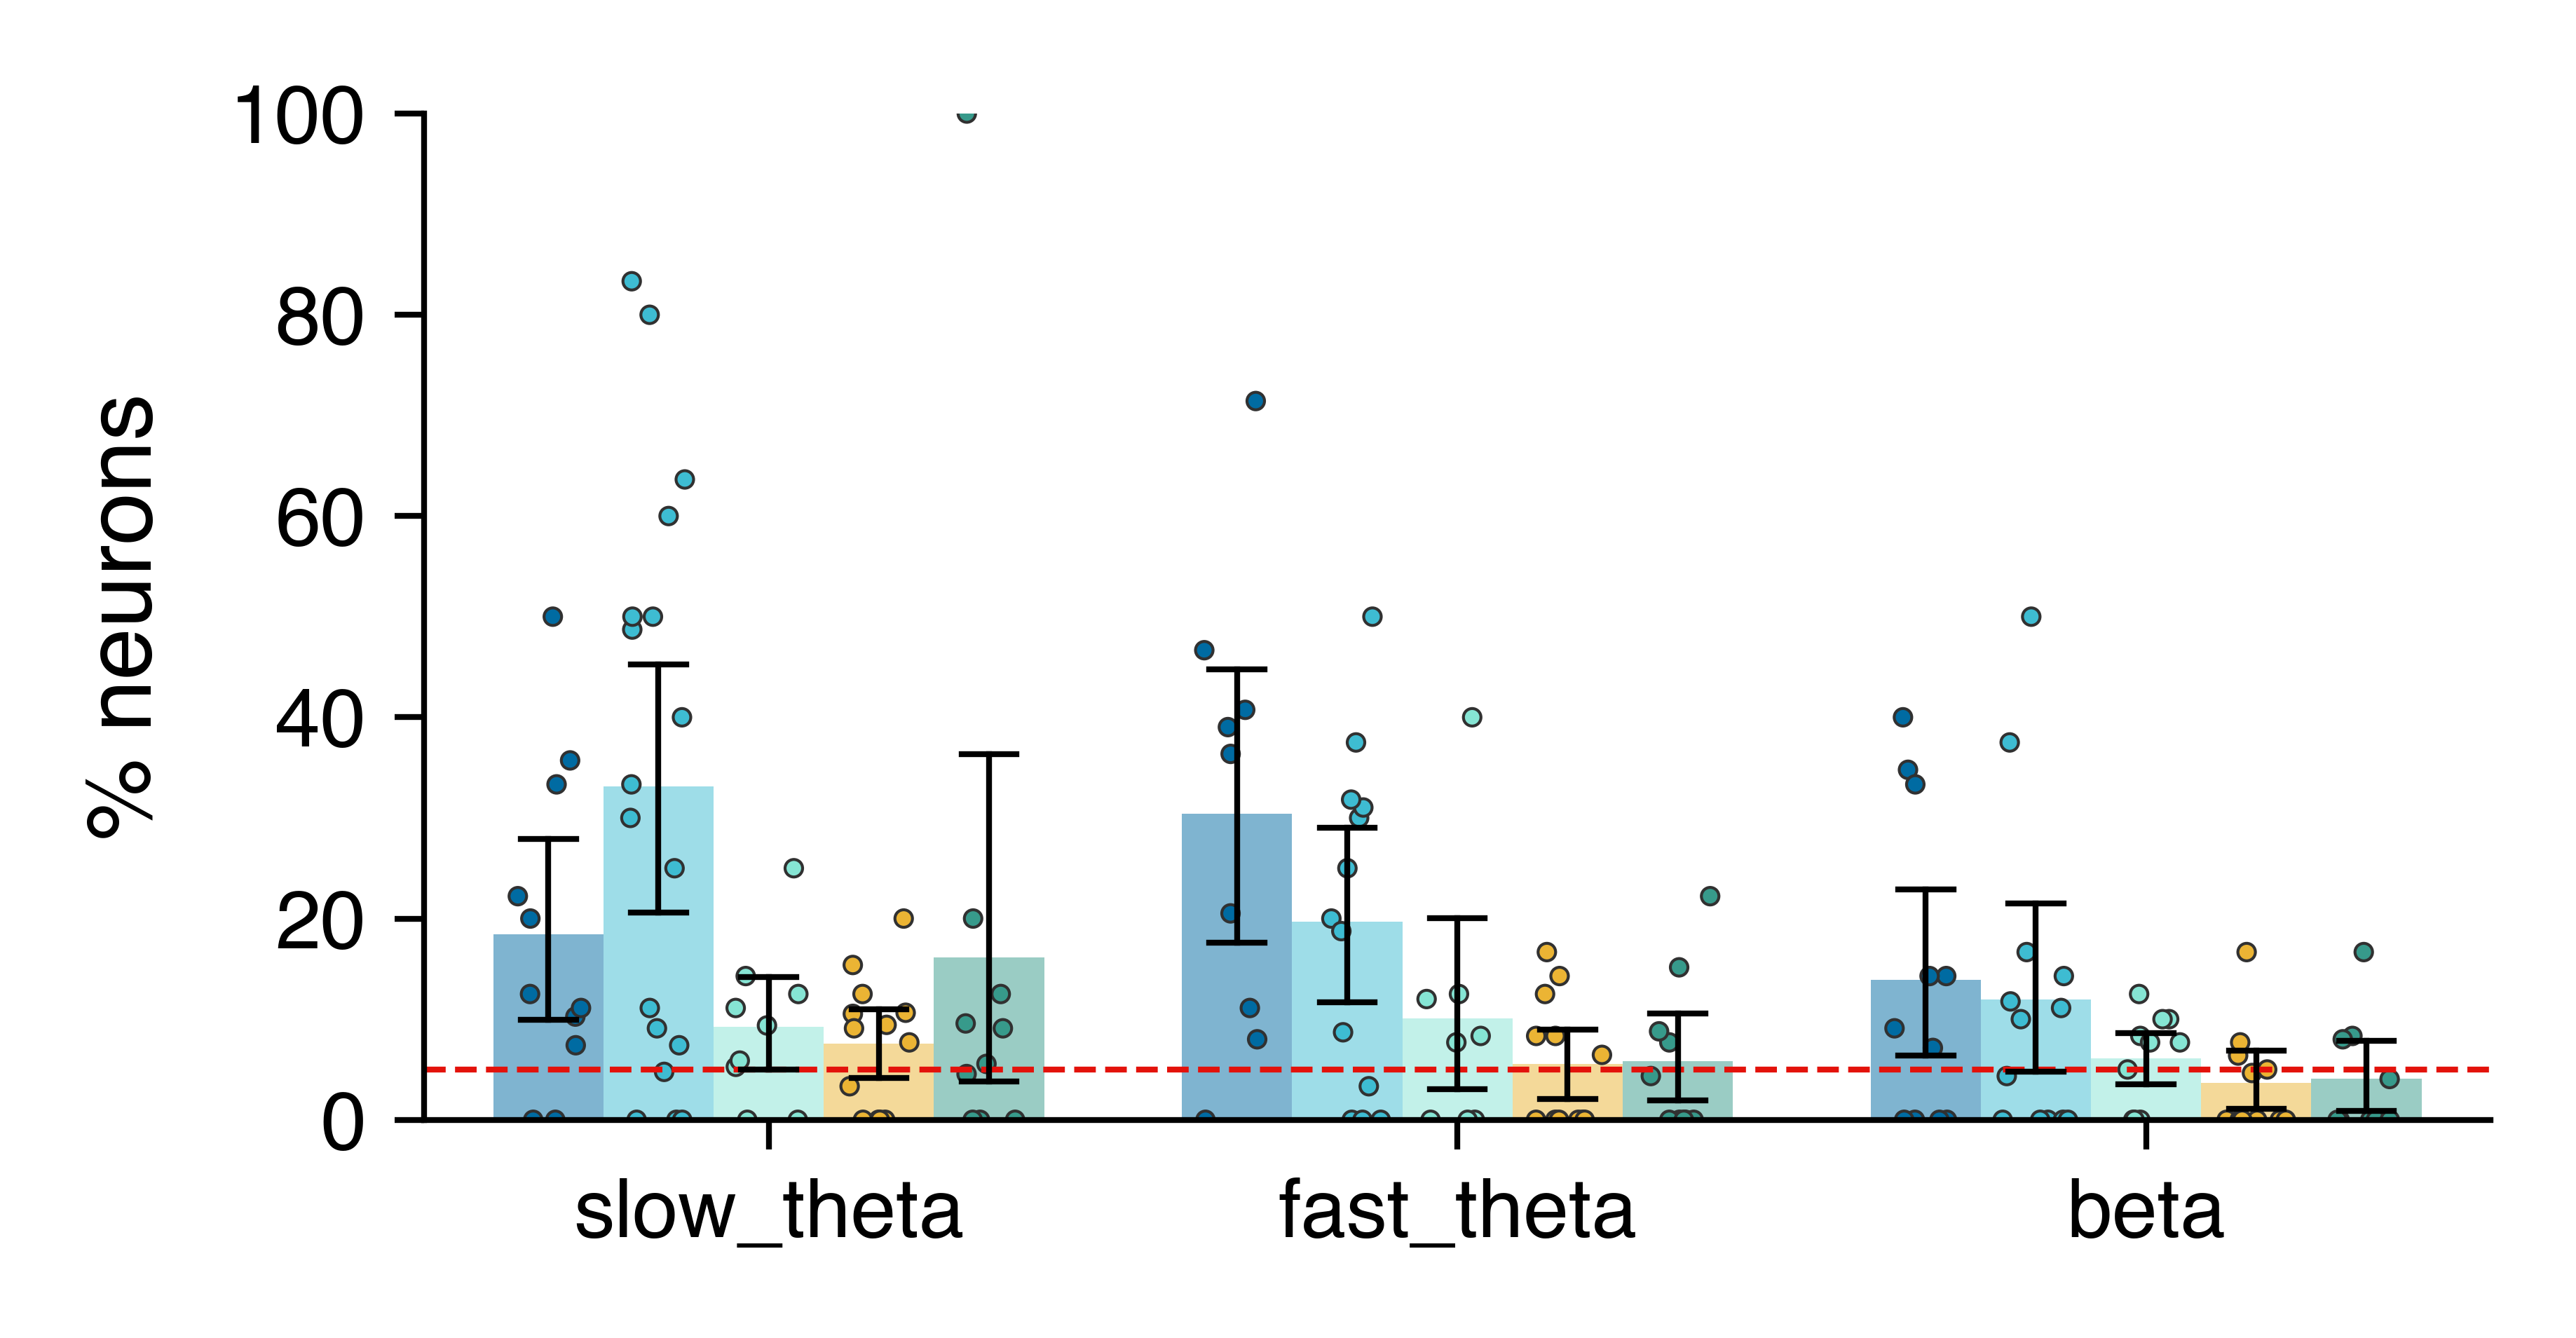

In [49]:
# Plot phase-locking percentage by band and region.
savefig = False
overwrite = False
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 100
yticks = [0, 20, 40, 60, 80, 100]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 0.5
stripsize = 1.5
jitter = 0.25
capsize = 2.5
palette = palettes['economist'][:5]
savefig = 0
overwrite = 0
keep_edges = ['ctx-hpc']
keep_bands = ['slow_theta', 'fast_theta', 'beta']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
band_sigs = []
for band in keep_bands:
    qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
           .format(keep_edges, band, min_spikes))
    band_sigs.append(pl_mrls
                     .query(qry)
                     .groupby(['subj', 'edge', 'unit_roi_gen'], observed=True)
                     .agg({'unit': len,
                           '{}_sig'.format(band): np.nanmean})
                     .query("(unit>={})".format(min_units))
                     .rename(columns={'{}_sig'.format(band): 'sig'}))
    band_sigs[-1].insert(0, 'band', band)
band_sigs = pd.concat(band_sigs, axis=0)
band_sigs = band_sigs.reset_index()
band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
mean_dat = (dat
            .groupby(['band', 'unit_roi_gen'])
            .agg({'sig': [np.mean, stats.sem]}))
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=co['r'], ls='--')
_ax = sns.barplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  ci=95, seed=1, errcolor='k', errwidth=spine_lw, capsize=0.08)
_ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                    palette=palette, size=stripsize, linewidth=spine_lw/2,
                    alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = (np.arange(len(keep_rois)) - (len(keep_rois)/2) + 0.5) * (0.8 / len(keep_rois))
# for iRoi, roi in enumerate(keep_rois):
#     _ax.errorbar(np.arange(len(keep_bands)) + xoffsets[iRoi],
#                  mean_dat.loc[(slice(None), roi), ('sig', 'mean')].values,
#                  yerr=mean_dat.loc[(slice(None), roi), ('sig', 'sem')].values * 1.96,
#                  ecolor='k', elinewidth=spine_lw, capsize=capsize,
#                  capthick=0.1, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_bands)))
_ax.set_xticklabels(keep_bands, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit-osc_pct-sig.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [52]:
qry

"(mask=='lfp_not_unit') & (edge==['ctx-hpc']) & (same_hem==True) & (beta_n_spikes_mask>=30)"

In [67]:
dat = (pl_mrls.query(qry).groupby(['edge', 'unit_roi_gen'], observed=True)
       .agg({'unit': len,
       '{}_sig'.format(band): [np.nanmean, lambda x: _bootstrap(x, np.nanmean, thresh=0.05)]}))

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = np.array([r[0]])


In [68]:
# dat.columns = ['unit', '{}_sig'.format(band), 'bootstrap']
# dat['{}_sig_95ci'.format(band)] = dat['bootstrap'].apply(lambda x: tuple(x[0]))
# dat['{}_sig_pval'.format(band)] = dat['bootstrap'].apply(lambda x: x[1])
# dat.drop(columns=['bootstrap'], inplace=True)
dat

unit slow_theta_sig  \
                      len        nanmean   
edge    unit_roi_gen                       
ctx-hpc EC            224       0.196429   
        A             258       0.286822   
        PHG-FSG       153       0.084967   
        mPFC          266       0.082707   
        O             260       0.115385   

                                                                         
                                                             <lambda_0>  
edge    unit_roi_gen                                                     
ctx-hpc EC            ([0.14732142857142858, 0.25], 9.99900009999000...  
        A             ([0.23255813953488372, 0.34108527131782945], 9...  
        PHG-FSG       ([0.0457516339869281, 0.13071895424836602], 0....  
        mPFC          ([0.05263157894736842, 0.11654135338345864], 0...  
        O             ([0.07692307692307693, 0.15384615384615385], 0...

In [73]:
# type1_err = 0.05
# band_sigs = []
# for band in keep_bands:
#     qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
#            .format(keep_edges, band, min_spikes))
#     band_sigs.append(pl_mrls
#                      .query(qry)
#                      .groupby(['edge', 'unit_roi_gen'], observed=True)
#                      .agg({'unit': len,
#                            '{}_sig'.format(band): [np.nanmean,
#                                                    lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
#     band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
#     band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
#     band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
#     band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
#     band_sigs[-1].insert(0, 'band', band)
# band_sigs = pd.concat(band_sigs, axis=0)
# band_sigs = band_sigs.reset_index()
# band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
dat

,edge,unit_roi_gen,band,unit,sig,sig_95ci,sig_pval
0,ctx-hpc,EC,slow_theta,224,19.642857,"(14.732142857142858, 25.0)",0.000100
1,ctx-hpc,A,slow_theta,258,28.682171,"(23.25581395348837, 34.49612403100775)",0.000100
2,ctx-hpc,PHG-FSG,slow_theta,153,8.496732,"(4.57516339869281, 13.071895424836603)",0.047195
3,ctx-hpc,mPFC,slow_theta,266,8.270677,"(5.263157894736842, 11.654135338345863)",0.024198
4,ctx-hpc,O,slow_theta,260,11.538462,"(7.6923076923076925, 15.384615384615385)",0.000500
5,ctx-hpc,EC,fast_theta,206,29.126214,"(23.300970873786408, 35.43689320388349)",0.000100
6,ctx-hpc,A,fast_theta,206,19.417476,"(14.077669902912621, 24.75728155339806)",0.000100
7,ctx-hpc,PHG-FSG,fast_theta,123,10.569106,"(5.691056910569105, 16.260162601626014)",0.021798
8,ctx-hpc,mPFC,fast_theta,216,6.481481,"(3.7037037037037033, 10.185185185185185)",0.168883
9,ctx-hpc,O,fast_theta,227,7.488987,"(4.405286343612335, 11.013215859030836)",0.072693


In [87]:
dat.query("(unit_roi_gen=='{}')".format('EC'))

,edge,unit_roi_gen,band,unit,sig,sig_95ci,sig_pval
0,ctx-hpc,EC,slow_theta,224,19.642857,"(14.732142857142858, 25.0)",0.0001
5,ctx-hpc,EC,fast_theta,206,29.126214,"(23.300970873786408, 35.43689320388349)",0.0001
10,ctx-hpc,EC,beta,172,13.372093,"(8.720930232558139, 18.6046511627907)",0.0004


In [92]:
np.array(dat.query("(unit_roi_gen=='{}')".format('O'))['sig_95ci'].tolist()).T

array([[ 7.69230769,  4.40528634,  0.96618357],
       [15.38461538, 11.01321586,  6.28019324]])

In [104]:
pl_mrls.columns

Index(['expmt', 'subj_sess_unit', 'subj', 'subj_sess', 'unit', 'unit_hemroi',
       'unit_roi_gen', 'unit_roi_gen2', 'n_spikes', 'fr', 'lfp_hemroi',
       'lfp_hpc_div', 'lfp_roi_gen', 'lfp_roi_gen2', 'lfp_chans', 'edge',
       'same_hem', 'same_roi_gen', 'mask', 'peps', 'max_pep', 'max_pep_freq',
       'n_spikes_mask', 'max_n_spikes_mask', 'n_spikes_mask_null', 'mrls',
       'mrls_null', 'pref_phases', 'max_z_pref_phase', 'z_n_spikes_mask',
       'z_mrls', 'max_z_mrl', 'max_z_mrl_freq', 'pval', 'sig', 'slow_theta',
       'slow_theta_n_spikes_mask', 'slow_theta_z_mrl', 'slow_theta_pval',
       'slow_theta_sig', 'fast_theta', 'fast_theta_n_spikes_mask',
       'fast_theta_z_mrl', 'fast_theta_pval', 'fast_theta_sig', 'beta',
       'beta_n_spikes_mask', 'beta_z_mrl', 'beta_pval', 'beta_sig',
       'slow_gamma', 'slow_gamma_n_spikes_mask', 'slow_gamma_z_mrl',
       'slow_gamma_pval', 'slow_gamma_sig'],
      dtype='object')

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = np.array([r[0]])


min = 5.5, max = 24.9


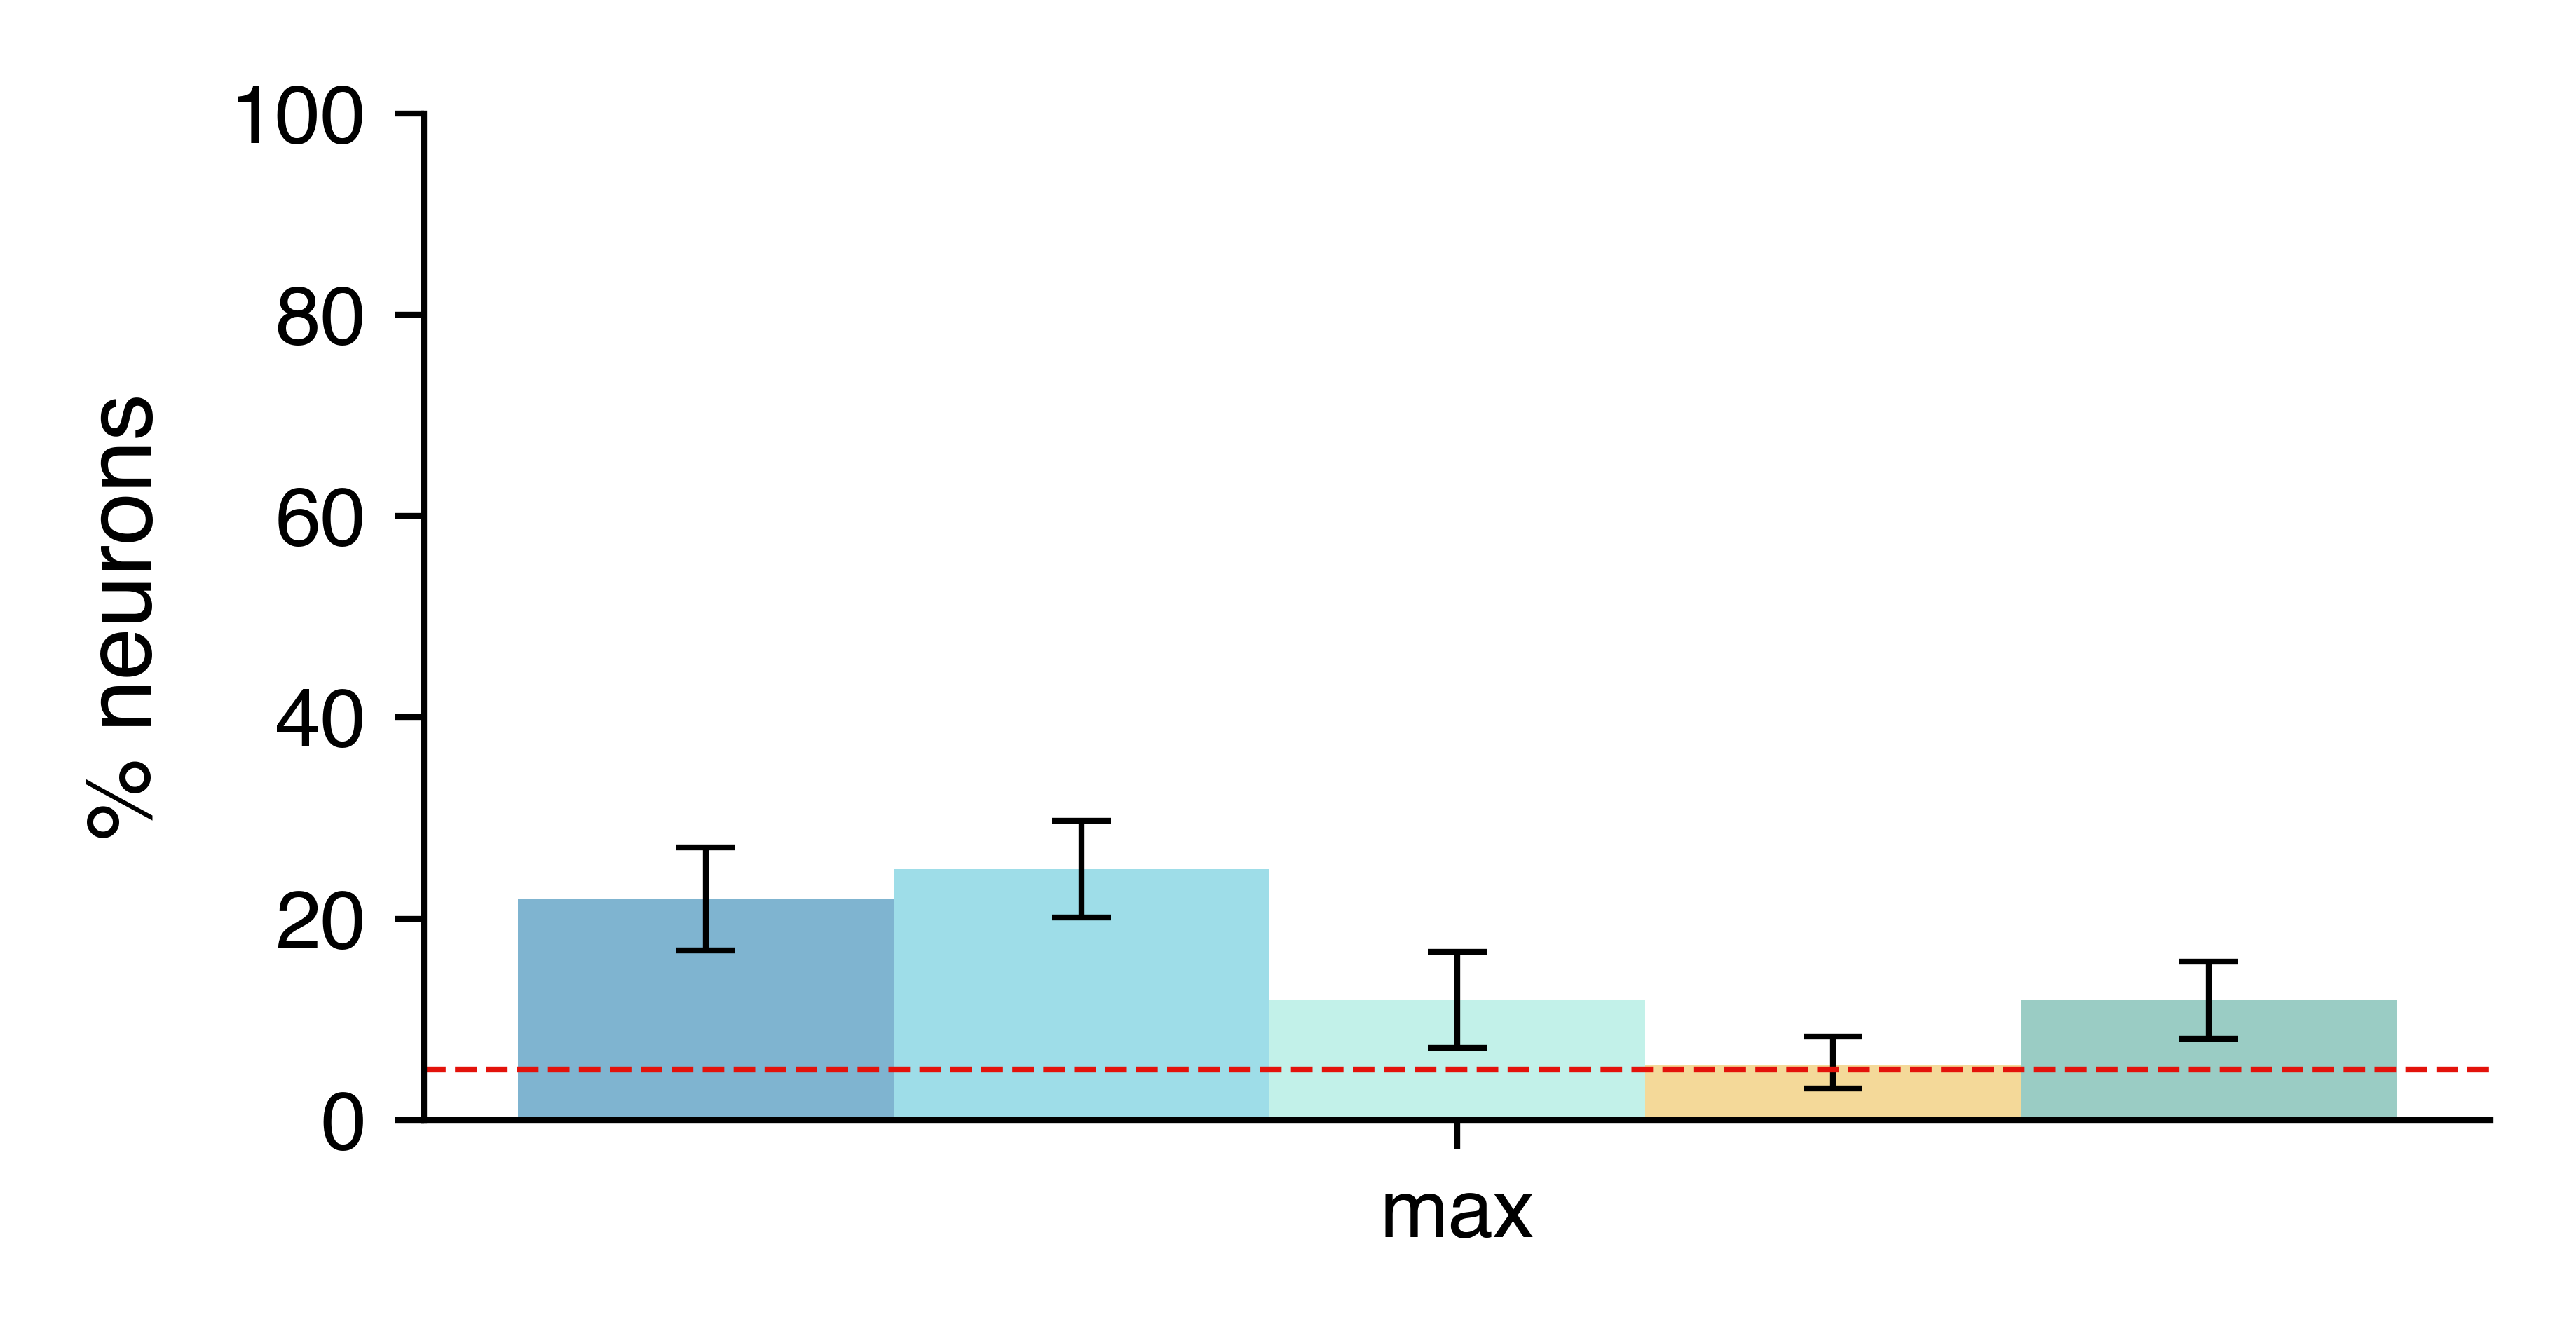

In [106]:
# Plot phase-locking percentage by band and region.
savefig = False
overwrite = False
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 100
yticks = [0, 20, 40, 60, 80, 100]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 0.5
stripsize = 1.5
jitter = 0.25
capsize = 2.5
palette = palettes['economist'][:5]
savefig = 0
overwrite = 0
keep_edges = ['ctx-hpc']
keep_bands = ['max']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
type1_err = 0.05
band_sigs = []
qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(keep_edges, min_spikes))
band_sigs.append(pl_mrls
                 .query(qry)
                 .groupby(['edge', 'unit_roi_gen'], observed=True)
                 .agg({'unit': len,
                       'sig': [np.nanmean, lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
band_sigs[-1].insert(0, 'band', 'max')
band_sigs = pd.concat(band_sigs, axis=0)
band_sigs = band_sigs.reset_index()
band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=co['r'], ls='--')
_ax = sns.barplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  ci=None)
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = (np.arange(len(keep_rois)) - (len(keep_rois)/2) + 0.5) * (0.8 / len(keep_rois))
for iRoi, roi in enumerate(keep_rois):
    _ax.errorbar(np.arange(len(keep_bands)) + xoffsets[iRoi],
                 dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values,
                 yerr=np.abs(dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values[None, :] - np.array(dat.query("(unit_roi_gen=='{}')".format(roi))['sig_95ci'].tolist()).T),
                 ecolor='k', elinewidth=spine_lw, capsize=capsize,
                 capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_bands)))
_ax.set_xticklabels(keep_bands, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit-osc_pct-sig.pdf')
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

1219 neurons
min = 3.4, max = 29.1
CI: min = 1.0, max = 35.4
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/pct_sig/ctx-hpc_lfp-not-unit-osc_pct-sig_across-1219-neurons.pdf


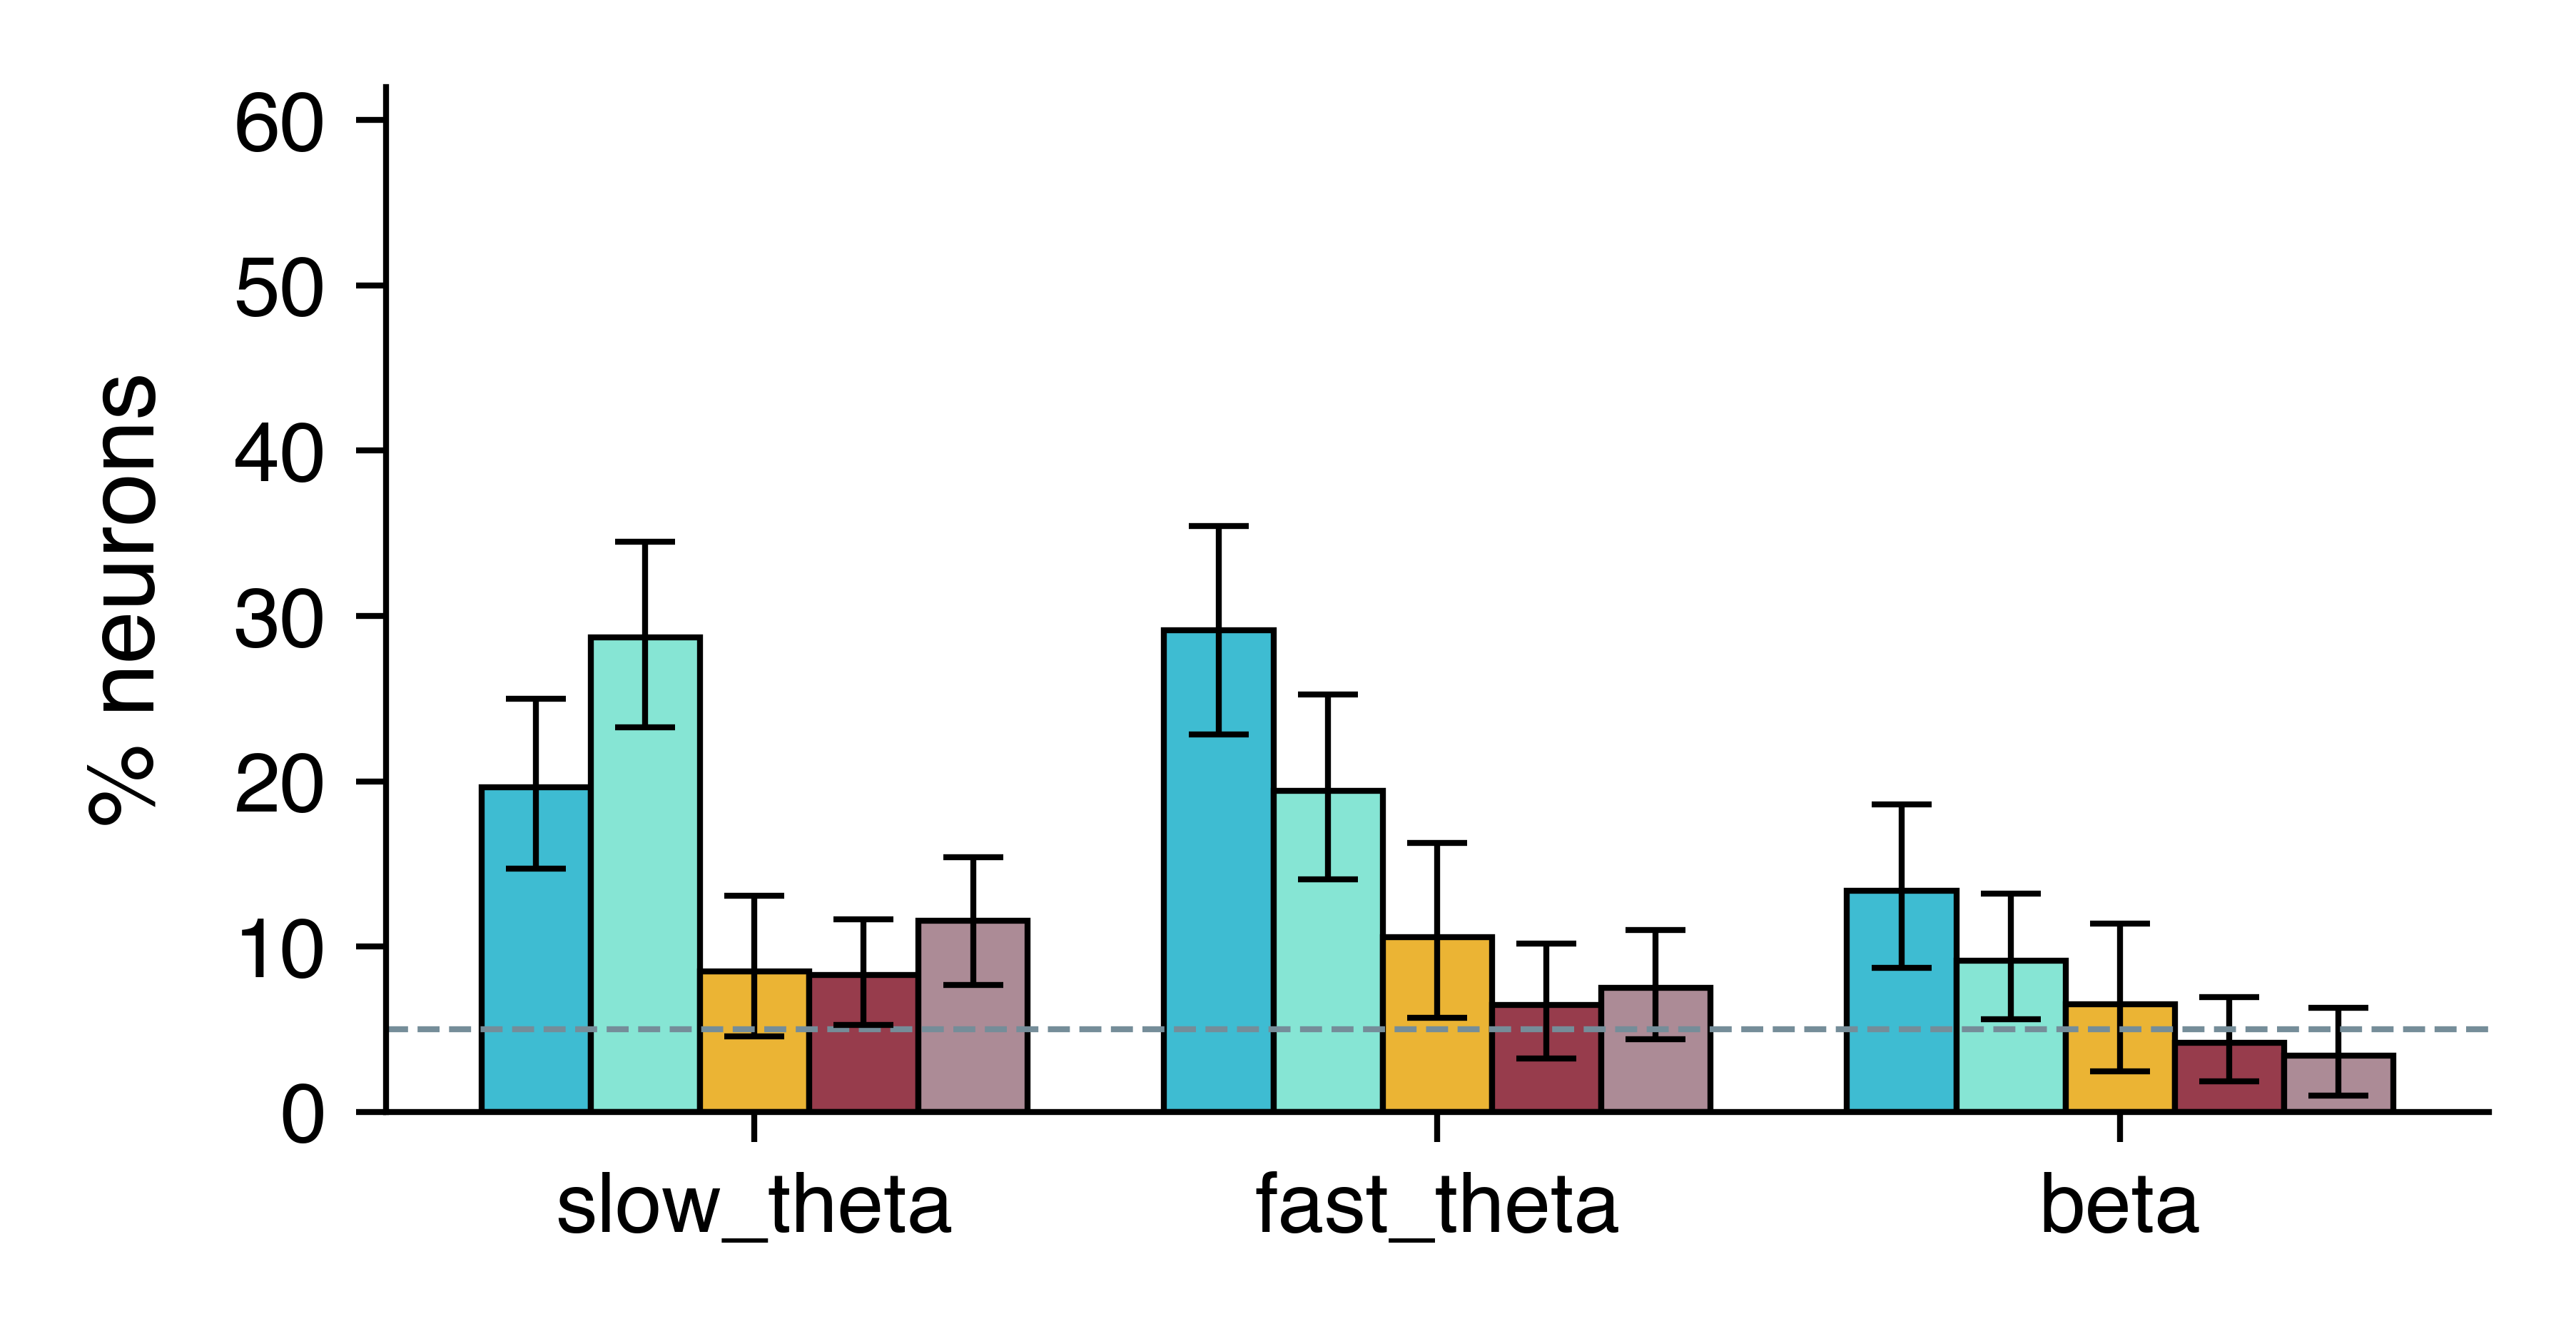

In [112]:
# Plot phase-locking percentage by band and region.
savefig = 0
overwrite = 1
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 62
yticks = [0, 10, 20, 30, 40, 50, 60]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']
palette = [co['b'], co['c'], co['lg'], co['y'], co['m'], co['lm']][1:]
keep_edges = ['ctx-hpc']
keep_bands = ['slow_theta', 'fast_theta', 'beta']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
n_units = pd.concat([pl_mrls.query(("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
                            .format(keep_edges, band, min_spikes)))
                     for band in keep_bands])['subj_sess_unit'].unique().size
print('{} neurons'.format(n_units))

# type1_err = 0.05
# band_sigs = []
# for band in keep_bands:
#     qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & ({}_n_spikes_mask>={})"
#            .format(keep_edges, band, min_spikes))
#     band_sigs.append(pl_mrls
#                      .query(qry)
#                      .groupby(['edge', 'unit_roi_gen'], observed=True)
#                      .agg({'unit': len,
#                            '{}_sig'.format(band): [np.nanmean,
#                                                    lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
#     band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
#     band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
#     band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
#     band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
#     band_sigs[-1].insert(0, 'band', band)
# band_sigs = pd.concat(band_sigs, axis=0)
# band_sigs = band_sigs.reset_index()
# band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))
print('CI: min = {:.1f}, max = {:.1f}'.format(dat['sig_95ci'].apply(lambda x: x[0]).min(), dat['sig_95ci'].apply(lambda x: x[1]).max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.barplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  lw=spine_lw, ec='k', ci=None)
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = (np.arange(len(keep_rois)) - (len(keep_rois)/2) + 0.5) * (0.8 / len(keep_rois))
for iRoi, roi in enumerate(keep_rois):
    _ax.errorbar(np.arange(len(keep_bands)) + xoffsets[iRoi],
                 dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values,
                 yerr=np.abs(dat.query("(unit_roi_gen=='{}')".format(roi))['sig'].values[None, :] - np.array(dat.query("(unit_roi_gen=='{}')".format(roi))['sig_95ci'].tolist()).T),
                 ecolor='k', elinewidth=spine_lw, capsize=capsize,
                 capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_bands)))
_ax.set_xticklabels(keep_bands, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit-osc_pct-sig_across-{}-neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

In [16]:
qry = ("(edge=={}) & (same_hem==True)".format(keep_edges, min_spikes))
pl_mrls.query(qry).groupby(['mask', 'edge', 'unit_roi_gen'], observed=True)['max_n_spikes_mask'].apply(median_q)

mask          edge     unit_roi_gen
lfp_and_unit  ctx-hpc  EC              123.38 (51.43, 318.88)
                       A                93.50 (34.25, 215.75)
                       PHG-FSG          67.93 (29.46, 167.68)
                       mPFC             85.00 (31.62, 195.50)
                       O               101.79 (35.66, 254.04)
lfp_not_unit  ctx-hpc  EC              188.88 (77.14, 473.71)
                       A               110.62 (40.00, 267.29)
                       PHG-FSG         165.09 (66.89, 421.26)
                       mPFC            157.29 (61.75, 375.88)
                       O               309.86 (78.34, 812.54)
Name: max_n_spikes_mask, dtype: object

In [19]:
alpha = 0.05
n_boot = 15000
method_boot = 'bca'
ci_output = 'lowhigh'
seed = None
keep_edges = ['ctx-hpc']
mask = 'lfp_not_unit'
sig_col = 'sig'

#  -------------------------
timer = Timer()

def _compfunc(sample_stat,
              alpha=0.05):
    return sample_stat <= alpha

print('min_spikes = {}, sig_col = {}'.format(min_spikes, sig_col), end='\n'*2)
qry = ("(mask=='{}') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(mask, keep_edges, min_spikes))
for (edge, unit_roi_gen), df in pl_mrls.query(qry).groupby(['edge', 'unit_roi_gen'], observed=True):
    n = len(df)
    n_sig  = df[sig_col].sum()
    mean_sig = df[sig_col].mean()
    if mean_sig > 0:
        ci, samp = boot.ci(df[sig_col].values.astype(bool),
                           statfunction=np.mean,
                           alpha=alpha,
                           n_samples=n_boot,
                           method=method_boot,
                           output=ci_output,                 
                           seed=seed,
                           return_dist=True,
                           use_numba=True)
        mean_samp = np.mean(samp)
        pval = boot.pval(df[sig_col].values.astype(bool),
                         statfunction=np.mean,
                         compfunction=_compfunc,
                         n_samples=n_boot,
                         seed=seed)
    else:
        ci = np.array((0.0, 0.0))
        mean_samp = 0.0
        pval = 1.0

    print('{}, {:>7}: sig = {}/{}, {:.1%} (samp_mean = {:.1%}, CI = {:.1%}-{:.1%}, P = {})'
          .format(edge, unit_roi_gen, n_sig, n, mean_sig, mean_samp, ci[0], ci[1], pval))
    
print()
print(timer)

min_spikes = 50, sig_col = sig

ctx-hpc,      EC: sig = 54/233, 23.2% (samp_mean = 23.2%, CI = 17.6%-28.3%, P = 0.0)
ctx-hpc,       A: sig = 73/263, 27.8% (samp_mean = 27.8%, CI = 22.1%-33.1%, P = 0.0)
ctx-hpc, PHG-FSG: sig = 19/151, 12.6% (samp_mean = 12.6%, CI = 7.3%-17.9%, P = 0.0011333333333333334)
ctx-hpc,    mPFC: sig = 15/265, 5.7% (samp_mean = 5.6%, CI = 3.0%-8.7%, P = 0.3526666666666667)
ctx-hpc,       O: sig = 32/260, 12.3% (samp_mean = 12.3%, CI = 8.5%-16.2%, P = 0.00013333333333333334)

Ran in 3.2s


In [20]:
alpha = 0.05
n_boot = 15000
method_boot = 'bca'
ci_output = 'lowhigh'
seed = None
keep_edges = ['ctx-hpc']
sig_col = 'sig_fdr'

#  -------------------------
timer = Timer()

def _compfunc(sample_stat,
              alpha=0.05):
    return sample_stat <= alpha

print('min_spikes = {}, sig_col = {}'.format(min_spikes, sig_col), end='\n'*2)
qry = ("(edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(keep_edges, min_spikes))
for (edge, unit_roi_gen), df in pl_mrls.query(qry).groupby(['edge', 'unit_roi_gen'], observed=True):
    n = len(df)
    n_sig  = df[sig_col].sum()
    mean_sig = df[sig_col].mean()
    if mean_sig > 0:
        ci, samp = boot.ci(df[sig_col].values.astype(bool),
                           statfunction=np.mean,
                           alpha=alpha,
                           n_samples=n_boot,
                           method=method_boot,
                           output=ci_output,                 
                           seed=seed,
                           return_dist=True,
                           use_numba=True)
        mean_samp = np.mean(samp)
        pval = boot.pval(df[sig_col].values.astype(bool),
                         statfunction=np.mean,
                         compfunction=_compfunc,
                         n_samples=n_boot,
                         seed=seed)
    else:
        ci = np.array((0.0, 0.0))
        mean_samp = 0.0
        pval = 1.0

    print('{}, {:>7}: sig = {}/{}, {:.1%} (samp_mean = {:.1%}, CI = {:.1%}-{:.1%}, P = {})'
          .format(edge, unit_roi_gen, n_sig, n, mean_sig, mean_samp, ci[0], ci[1], pval))
    
print()
print(timer)

min_spikes = 50, sig_col = sig_fdr

ctx-hpc,      EC: sig = 115/442, 26.0% (samp_mean = 26.0%, CI = 21.7%-30.1%, P = 0.0)
ctx-hpc,       A: sig = 125/523, 23.9% (samp_mean = 23.9%, CI = 20.3%-27.5%, P = 0.0)
ctx-hpc, PHG-FSG: sig = 0/256, 0.0% (samp_mean = 0.0%, CI = 0.0%-0.0%, P = 1.0)
ctx-hpc,    mPFC: sig = 10/482, 2.1% (samp_mean = 2.1%, CI = 0.8%-3.3%, P = 1.0)
ctx-hpc,       O: sig = 9/474, 1.9% (samp_mean = 1.9%, CI = 0.8%-3.2%, P = 1.0)

Ran in 2.5s


1313 neurons


/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/pandas/core/dtypes/cast.py:224: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr = np.array([r[0]])


min = 5.5, max = 24.9
CI: min = 3.1, max = 30.0
Saved /home1/dscho/projects/unit_activity_and_hpc_theta/figs2/pct_sig/ctx-hpc_lfp-not-unit_max-freq_pct-sig_across-1313-neurons.pdf


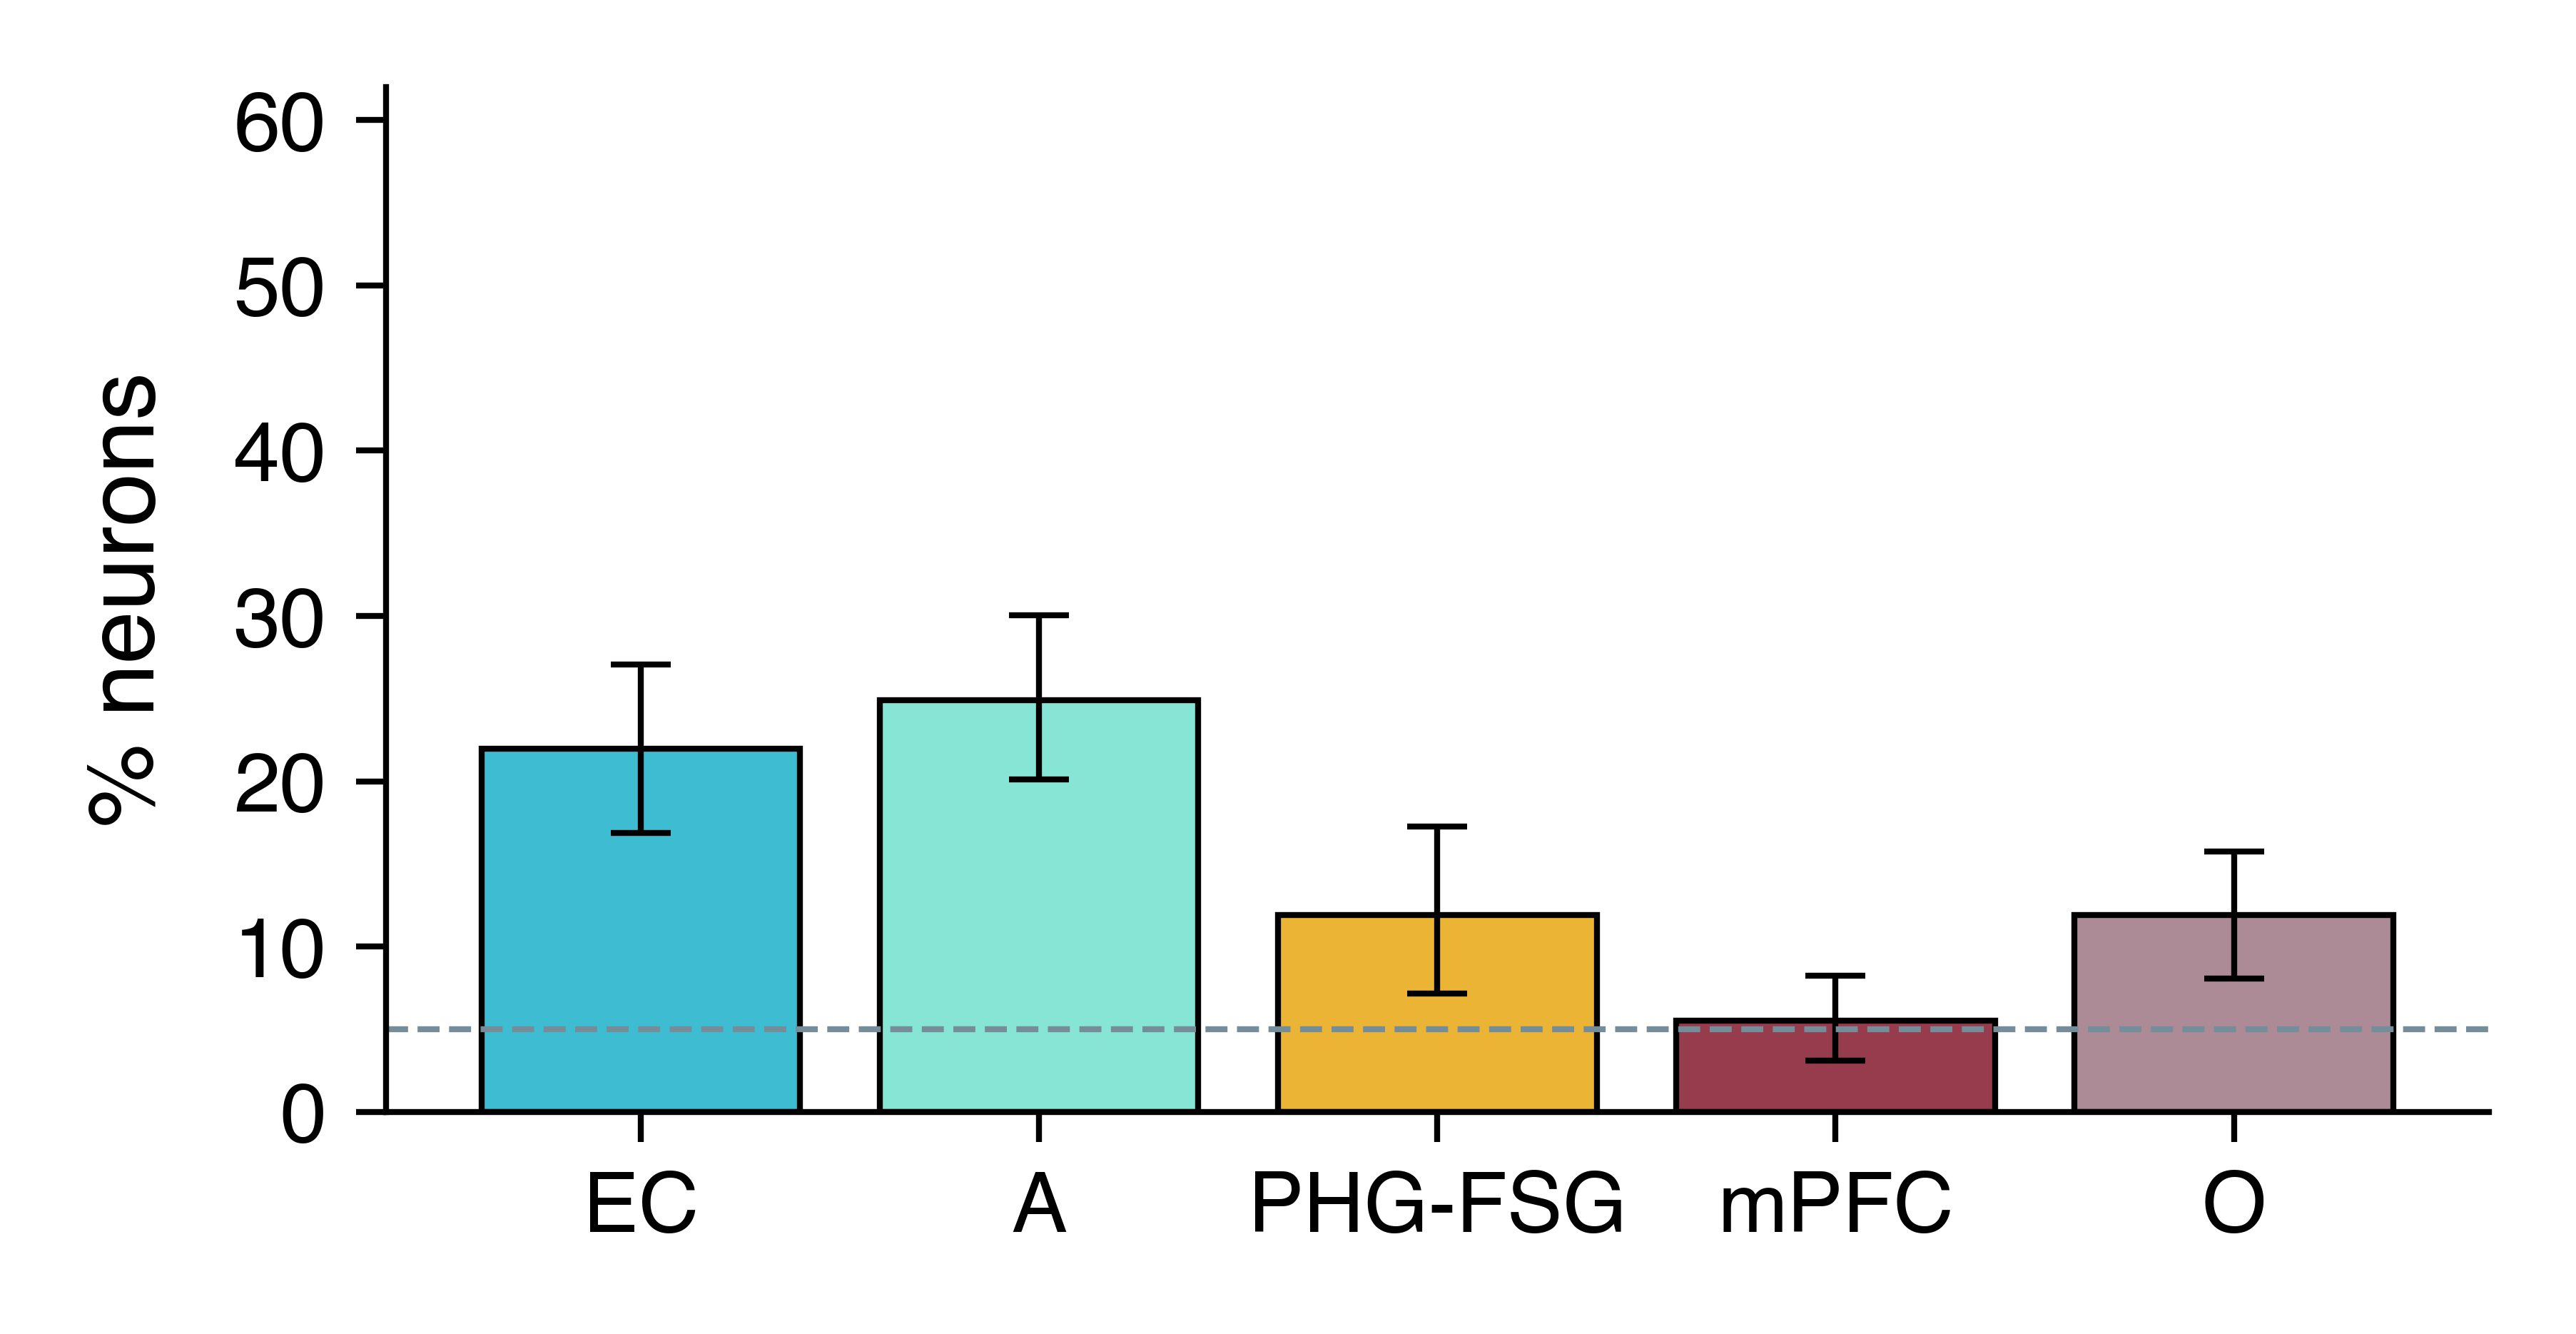

In [154]:
# Plot phase-locking percentage by region for the max phase-locking frequency.
savefig = 0
overwrite = 0
figsize = (colws[2], colws[2]*0.5)
dpi = 1200
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
ymin = 0
ymax = 62
yticks = [0, 10, 20, 30, 40, 50, 60]
spine_lw = 0.5
ticklen = 2.5
tickpad = 2.5
labelpad = 5
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']
palette = [co['b'], co['c'], co['lg'], co['y'], co['m'], co['lm']][1:]
keep_edges = ['ctx-hpc']
keep_bands = ['max']
keep_rois = ['EC', 'A', 'PHG-FSG', 'mPFC', 'O']
min_units = 5

# ----------------------------
# Get the data.
n_units = pl_mrls.query(("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
                         .format(keep_edges, min_spikes)))['subj_sess_unit'].unique().size
print('{} neurons'.format(n_units))

type1_err = 0.05
band_sigs = []
qry = ("(mask=='lfp_not_unit') & (edge=={}) & (same_hem==True) & (max_n_spikes_mask>={})"
       .format(keep_edges, min_spikes))
band_sigs.append(pl_mrls
                 .query(qry)
                 .groupby(['edge', 'unit_roi_gen'], observed=True)
                 .agg({'unit': len,
                       'sig': [np.nanmean, lambda x: _bootstrap(x, np.nanmean, thresh=type1_err)]}))
band_sigs[-1].columns = ['unit', 'sig', 'bootstrap']
band_sigs[-1]['sig_95ci'] = band_sigs[-1]['bootstrap'].apply(lambda x: tuple(100 * np.array(x[0])))
band_sigs[-1]['sig_pval'] = band_sigs[-1]['bootstrap'].apply(lambda x: x[1])
band_sigs[-1].drop(columns=['bootstrap'], inplace=True)
band_sigs[-1].insert(0, 'band', 'max')
band_sigs = pd.concat(band_sigs, axis=0)
band_sigs = band_sigs.reset_index()
band_sigs['sig'] *= 100

dat = band_sigs.query("(edge=={}) & (band=={})".format(keep_edges, keep_bands)).copy()
dat['edge'] = band_sigs['edge'].astype(str)
dat['band'] = band_sigs['band'].astype(pd.CategoricalDtype(keep_bands, ordered=True))
dat['unit_roi_gen'] = dat['unit_roi_gen'].astype(pd.CategoricalDtype(keep_rois, ordered=True))
dat = dat.sort_values(['band', 'unit_roi_gen']).reset_index(drop=True)
print('min = {:.1f}, max = {:.1f}'.format(dat['sig'].min(), dat['sig'].max()))
print('CI: min = {:.1f}, max = {:.1f}'.format(dat['sig_95ci'].apply(lambda x: x[0]).min(), dat['sig_95ci'].apply(lambda x: x[1]).max()))

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.barplot(x='unit_roi_gen', y='sig', data=dat, ax=_ax,
                  palette=palette, saturation=1, alpha=bar_alpha, zorder=0,
                  ci=None, lw=spine_lw, ec='k',)
# _ax = sns.stripplot(x='band', y='sig', hue='unit_roi_gen', data=dat, ax=_ax,
#                     palette=palette, size=stripsize, linewidth=spine_lw/2,
#                     alpha=1, dodge=True, jitter=jitter, zorder=1)
xoffsets = np.arange(len(keep_rois))
yerr = np.abs(dat['sig'].values[None, :] - np.array(dat['sig_95ci'].tolist()).T)
_ax.errorbar(np.arange(len(keep_rois)),
             dat['sig'].values,
             yerr=yerr,
             ecolor='k', elinewidth=spine_lw, capsize=capsize,
             capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(len(keep_rois)))
_ax.set_xticklabels(keep_rois, fontsize=font['tick'])
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('% neurons', fontsize=font['label'], labelpad=labelpad)
if _ax.get_legend():
    _ax.get_legend().remove()

if savefig:
    filename = op.join('/home1/dscho/projects/unit_activity_and_hpc_theta',
                       'figs2', 'pct_sig', 
                       'ctx-hpc_lfp-not-unit_max-freq_pct-sig_across-{}-neurons.pdf'.format(n_units))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        print('Saved {}'.format(filename))
        
fig.show()

# Region-to-region heatmaps

## Average across neurons

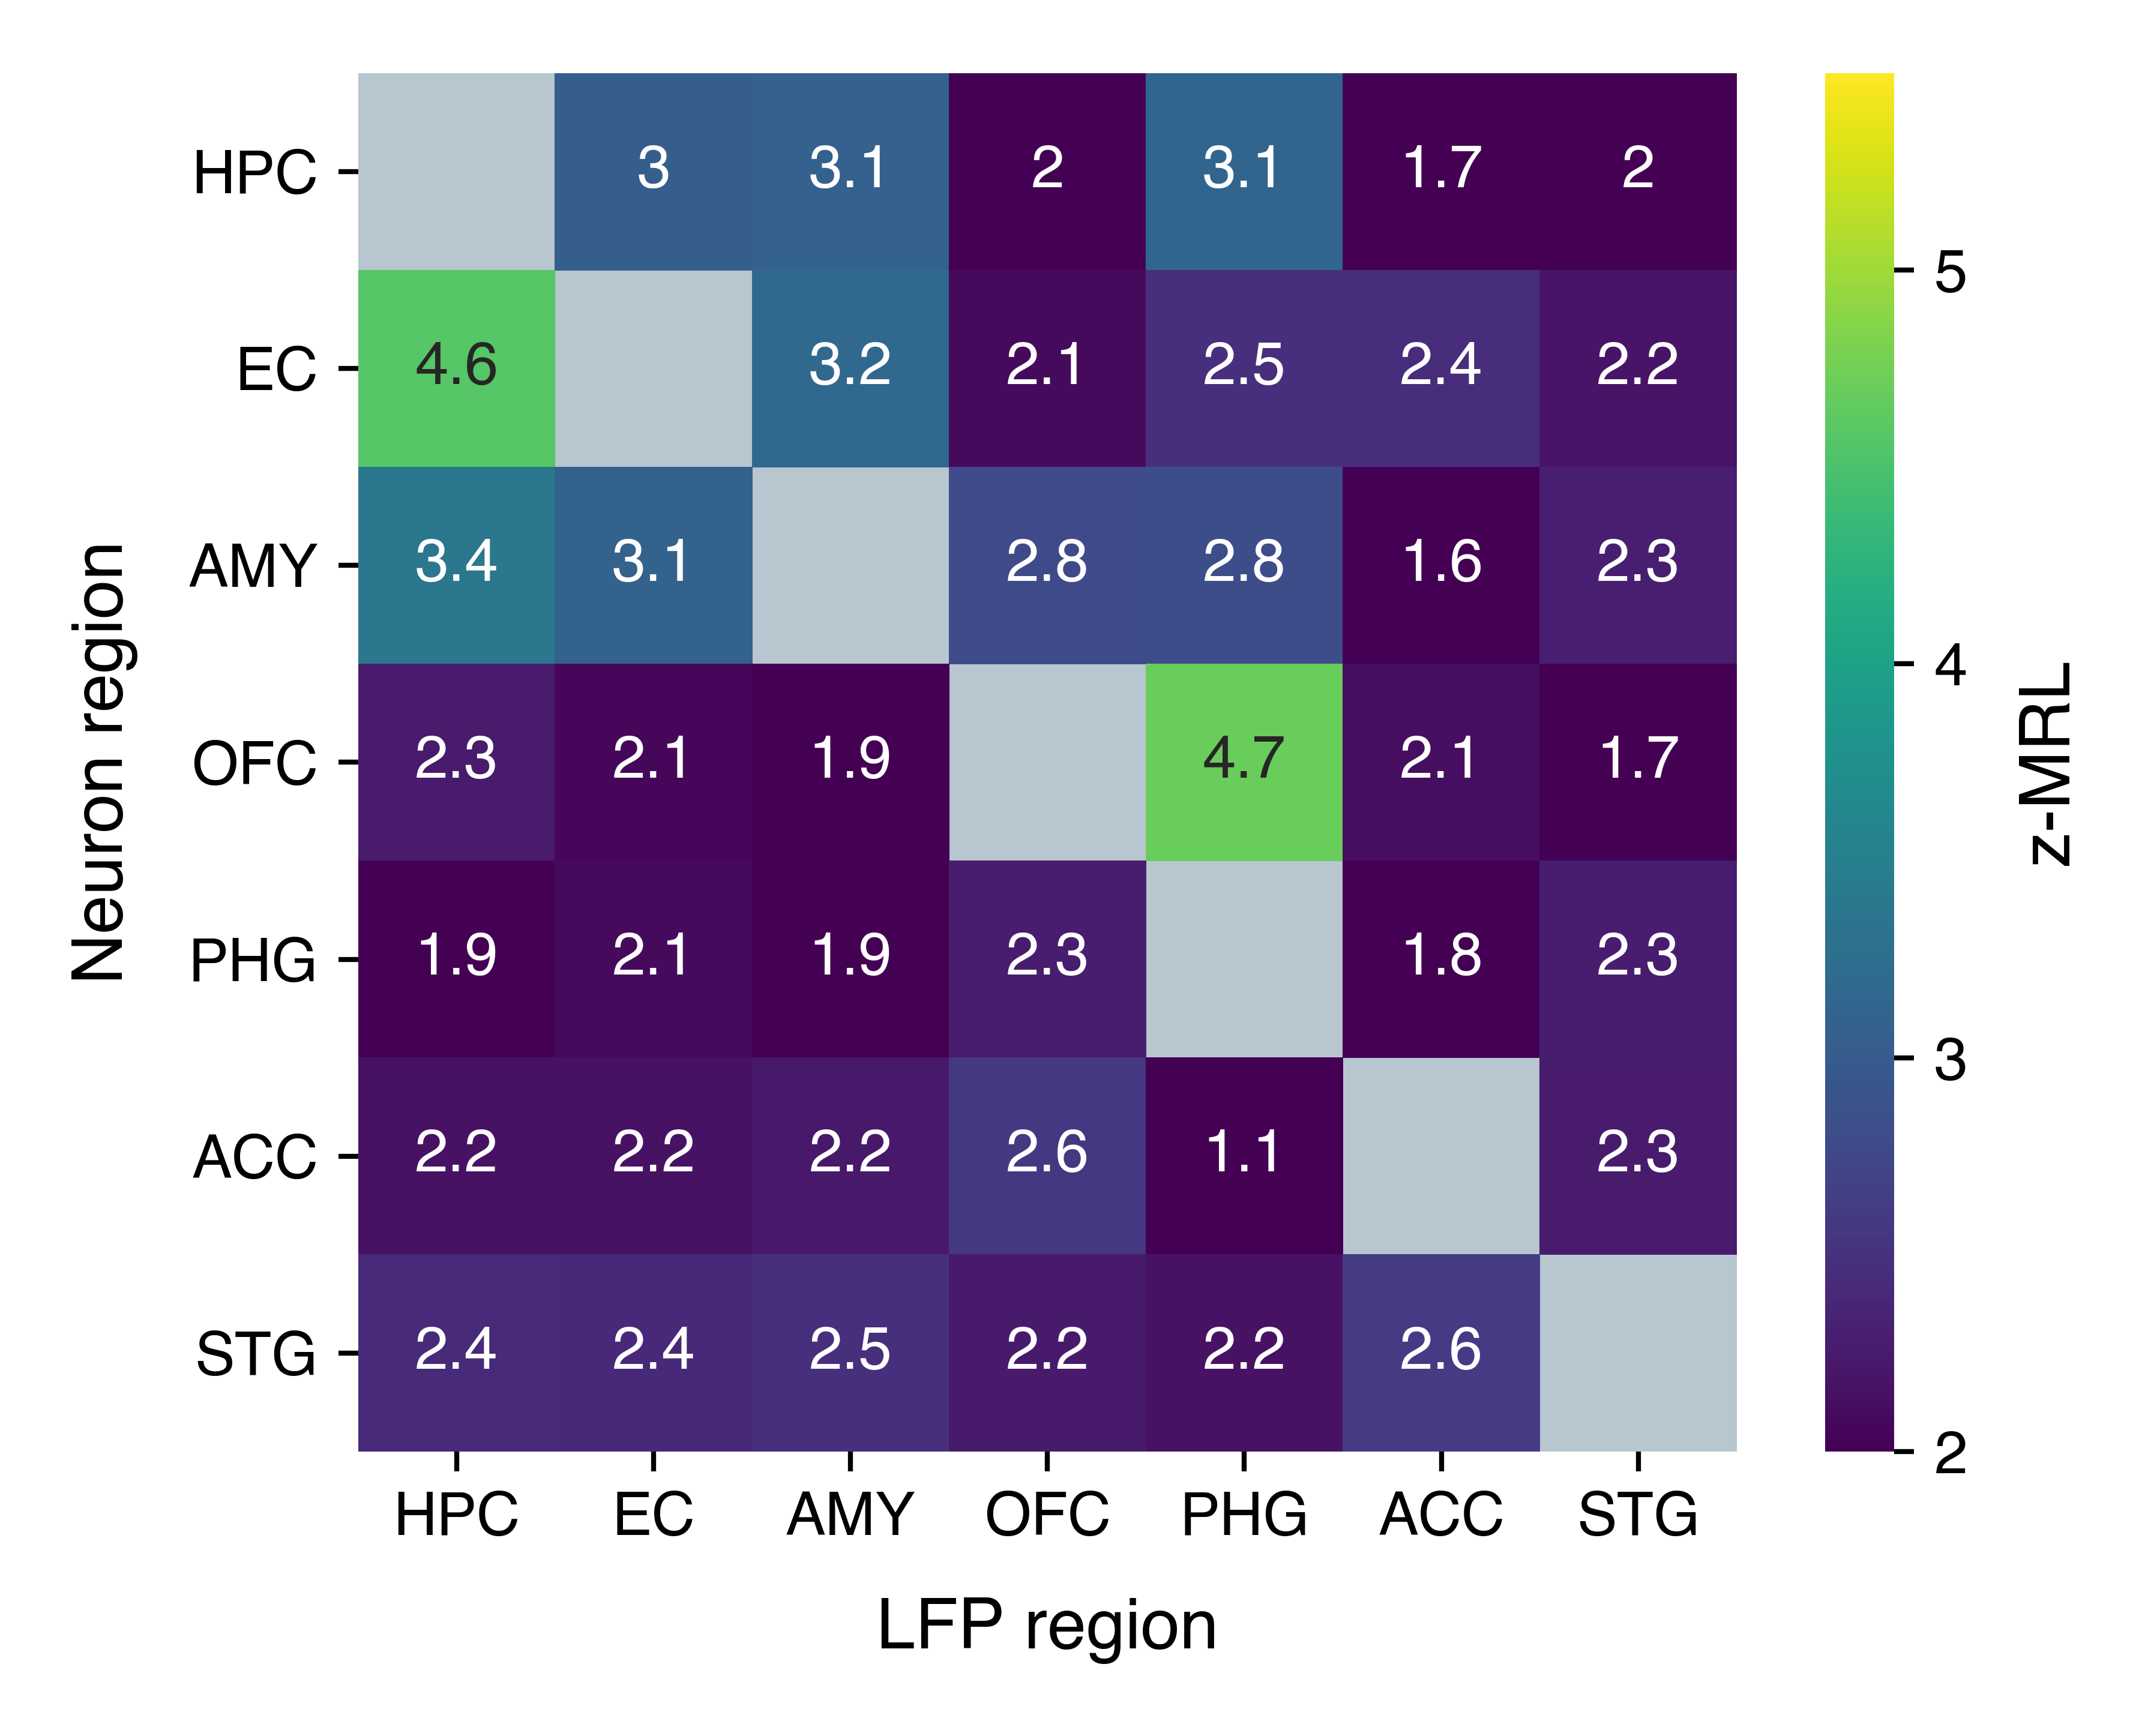

In [58]:
stat_col = 'max_z_mrl'
min_units = 5
min_subj = 4
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ax_facecolor = co['x2']
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'viridis'
vmin = 2
vmax = 5.5
cbarticks = [2, 3, 4, 5]
cbarlab = 'z-MRL'

# --------------------
# Get the data.
df = (pl_mrls
      .query("(mask=='lfp_and_unit')")
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'subj_sess_unit': lambda x: np.unique(x).size,
            stat_col: lambda x: 1 * np.mean(x)}))
df.columns = ['n_units', stat_col]
df = df.unstack('lfp_roi_gen')
dat = df[stat_col]

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, vmin=vmin, vmax=vmax, ax=_ax,
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.set_facecolor(ax_facecolor)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)

fig.show()

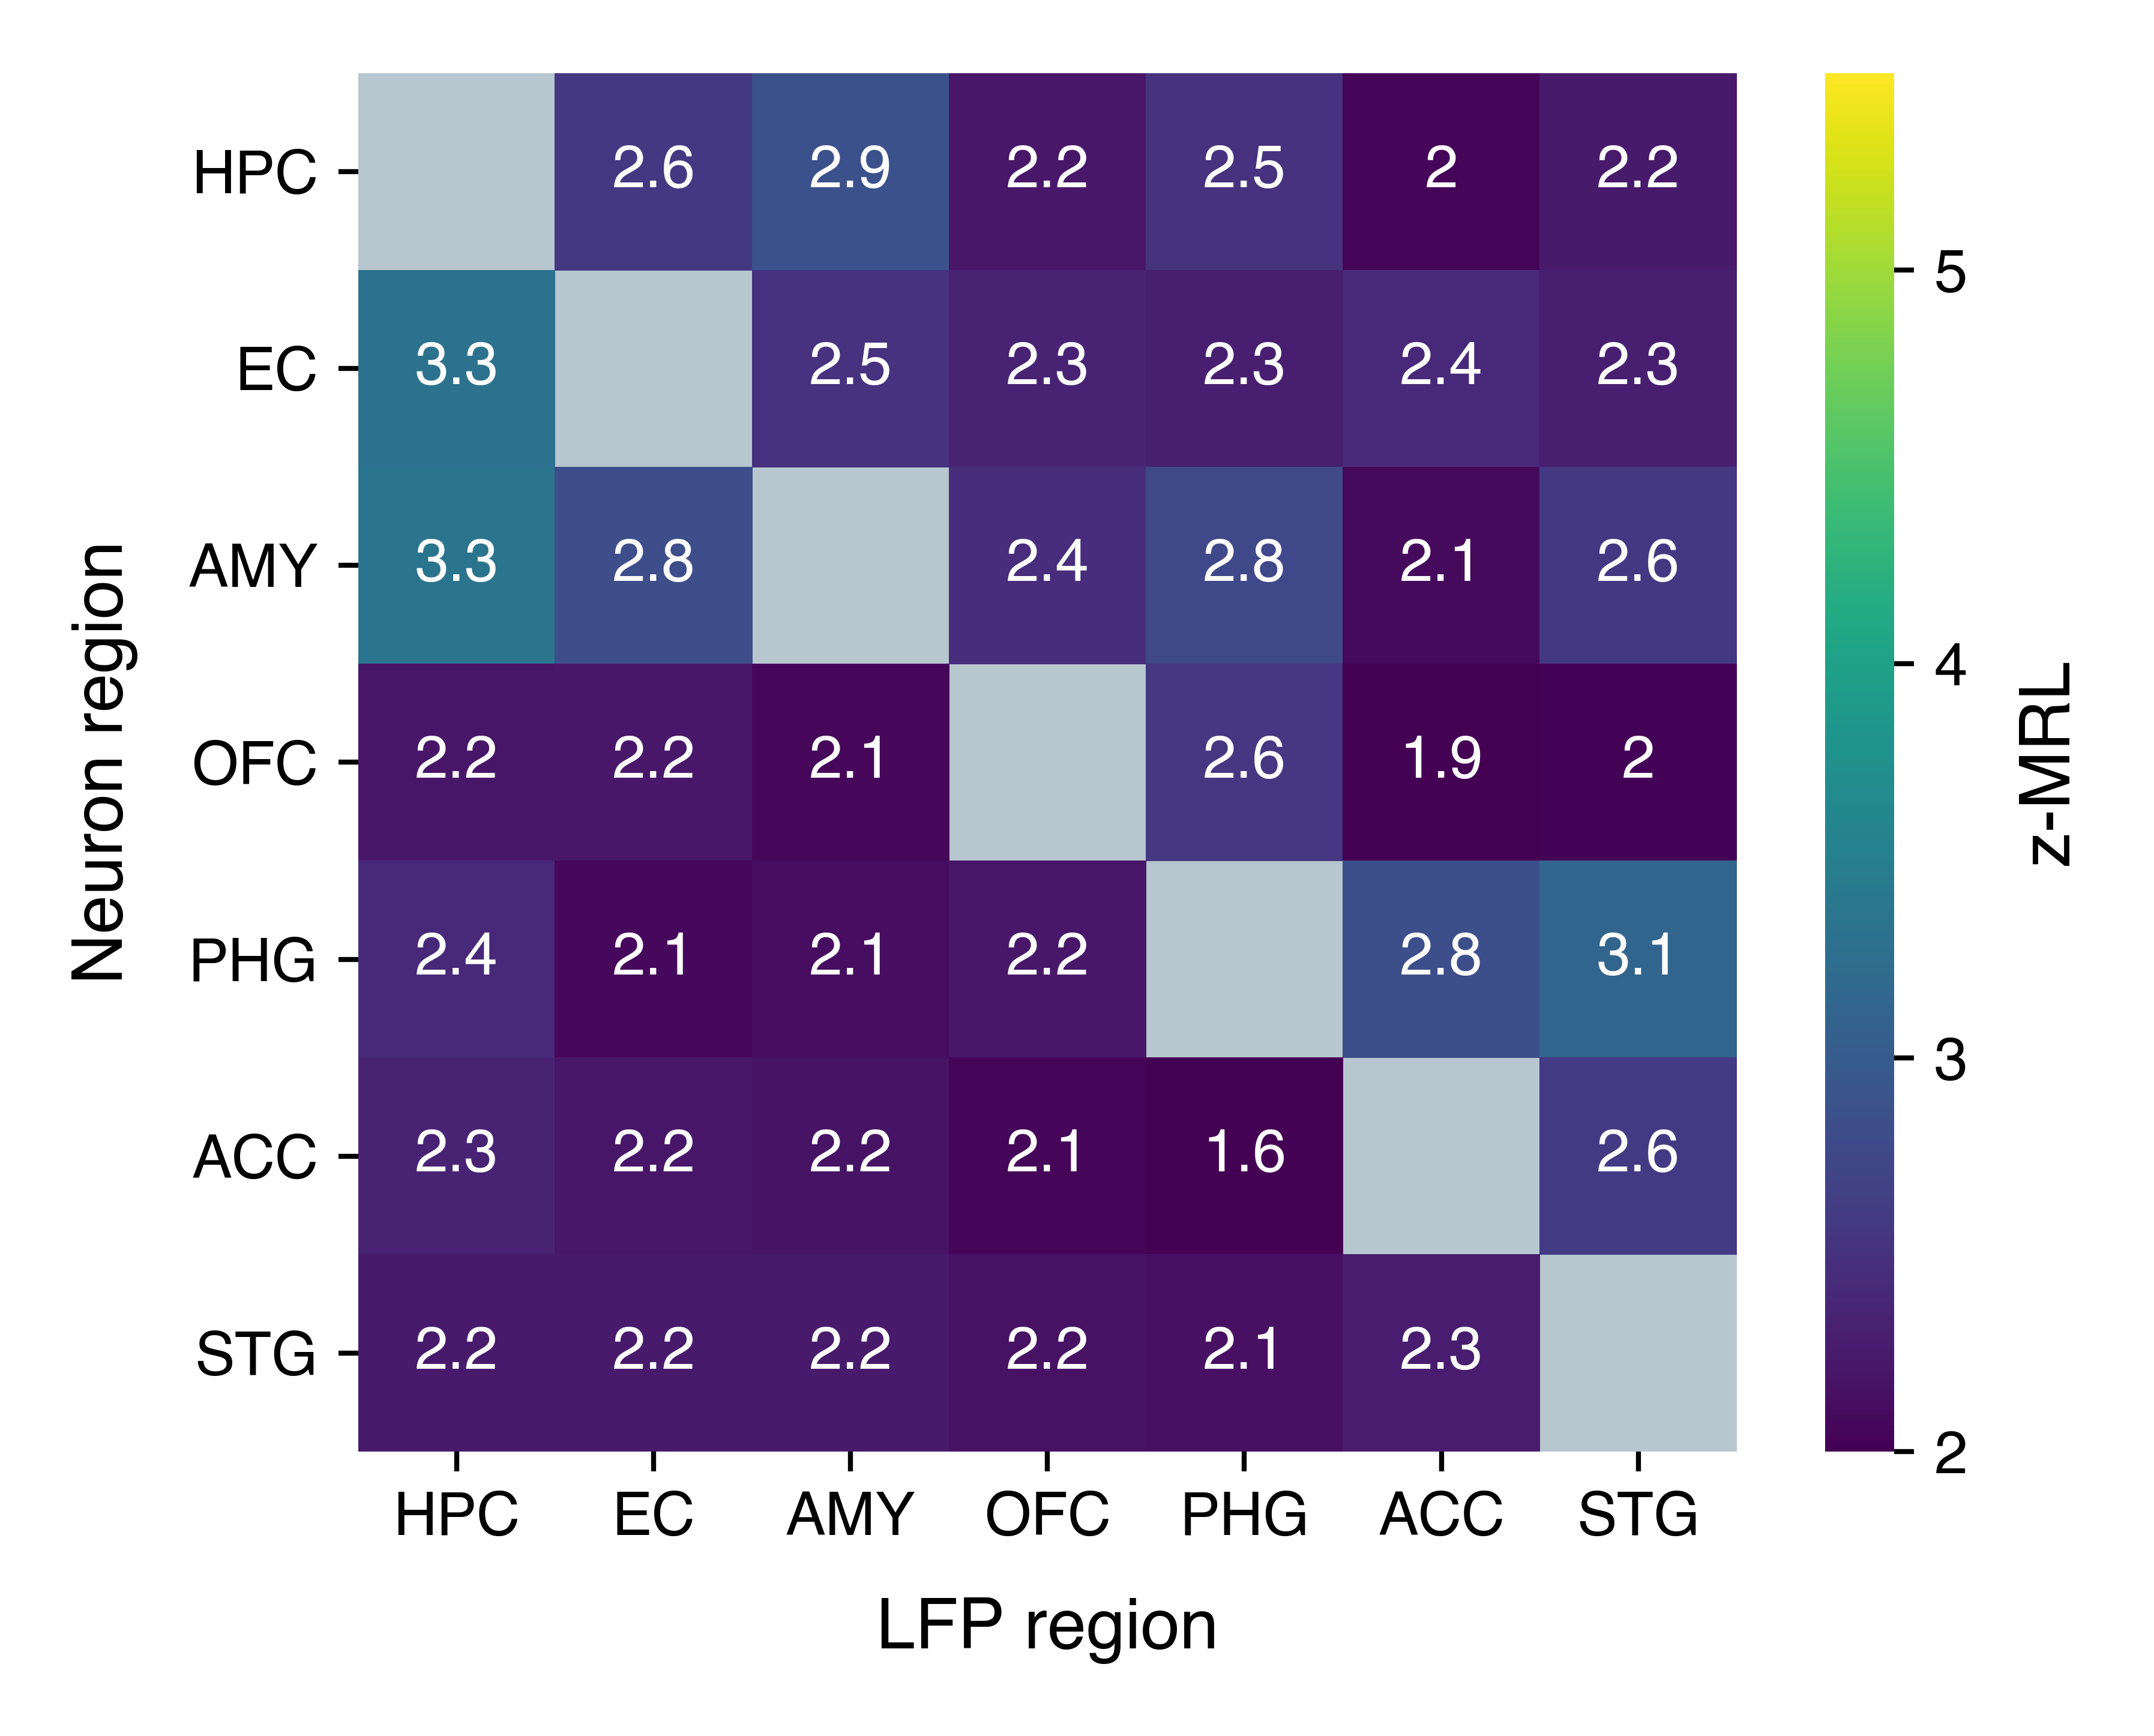

In [57]:
stat_col = 'max_z_mrl'
min_units = 5
min_subj = 4
figsize = (colws[2], colws[2]*0.8)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
ax_facecolor = co['x2']
spine_lw = 0.5
ticklen = 2
tickpad = 2
labelpad = 5
xticks = np.arange(len(gen_rois)) + 0.5
xticklabs = gen_rois
yticks = xticks
yticklabs = xticklabs
xlab = 'LFP region'
ylab = 'Neuron region'
cmap = 'viridis'
vmin = 2
vmax = 5.5
cbarticks = [2, 3, 4, 5]
cbarlab = 'z-MRL'

# --------------------
# Get the data.
df = (pl_mrls
      .query("(mask=='lfp_not_unit')")
      .query("((same_roi_gen==True) & (is_local==True)) | (same_roi_gen==False)")
      .groupby(['unit_roi_gen', 'lfp_roi_gen'])
      .agg({'subj_sess_unit': lambda x: np.unique(x).size,
            stat_col: lambda x: 1 * np.mean(x)}))
df.columns = ['n_units', stat_col]
df = df.unstack('lfp_roi_gen')
dat = df[stat_col]

# Make the plot.
plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_ax = sns.heatmap(dat, vmin=vmin, vmax=vmax, ax=_ax,
                  square=True, cmap=cmap, cbar=True, annot=True)

_ax.set_facecolor(ax_facecolor)
_ax.tick_params(labelsize=font['tick'], pad=tickpad, length=ticklen, width=spine_lw, rotation=0)
_ax.set_xticks(xticks)
_ax.set_xticklabels(xticklabs)
_ax.set_xlabel(xlab, fontsize=font['label'], labelpad=labelpad)
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticklabs)
_ax.set_ylabel(ylab, fontsize=font['label'], labelpad=labelpad)
cbar = _ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=font['tick'], length=ticklen, pad=tickpad, width=spine_lw)
cbar.set_ticks(cbarticks)
cbar.set_ticklabels(cbarticks)
cbar.set_label(cbarlab, fontsize=font['label'], labelpad=labelpad)

fig.show()